# Downloading the dataset from kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hotsonhonet","key":"e6cb444362df8bdc68a95a96af34b13c"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d atulyaatul1999/hackerearth-carnival-wars-challenge

  0% 0.00/425k [00:00<?, ?B/s]
100% 425k/425k [00:00<00:00, 63.0MB/s]


In [ ]:
!ls

hackerearth-carnival-wars-challenge.zip  kaggle.json  sample_data


In [ ]:
from zipfile import ZipFile

with ZipFile("hackerearth-carnival-wars-challenge.zip", 'r') as file:
    file.extractall()
file.close()

# Installing catboost

In [ ]:
!pip install catboost

     |████████████████████████████████| 66.3MB 67kB/s 


# Importing modules

In [ ]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

from collections import Counter
import glob

import warnings
warnings.filterwarnings('ignore')

import cv2
import imutils
import scipy
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error, make_scorer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor


%matplotlib inline

# Loading our dataset

In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Shape of train_df : {train_df.shape}")
print(f"Shape of test_df : {test_df.shape}")

Shape of train_df : (6368, 15)
Shape of test_df : (3430, 14)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6368 entries, 0 to 6367
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_id        6368 non-null   object 
 1   Stall_no          6363 non-null   float64
 2   instock_date      6368 non-null   object 
 3   Market_Category   6368 non-null   int64  
 4   Customer_name     6157 non-null   object 
 5   Loyalty_customer  6368 non-null   object 
 6   Product_Category  6368 non-null   object 
 7   Grade             6368 non-null   int64  
 8   Demand            6368 non-null   int64  
 9   Discount_avail    6330 non-null   float64
 10  charges_1         6170 non-null   float64
 11  charges_2 (%)     6163 non-null   float64
 12  Minimum_price     6330 non-null   float64
 13  Maximum_price     6025 non-null   float64
 14  Selling_Price     6327 non-null   float64
dtypes: float64(7), int64(3), object(5)
memory usage: 746.4+ KB


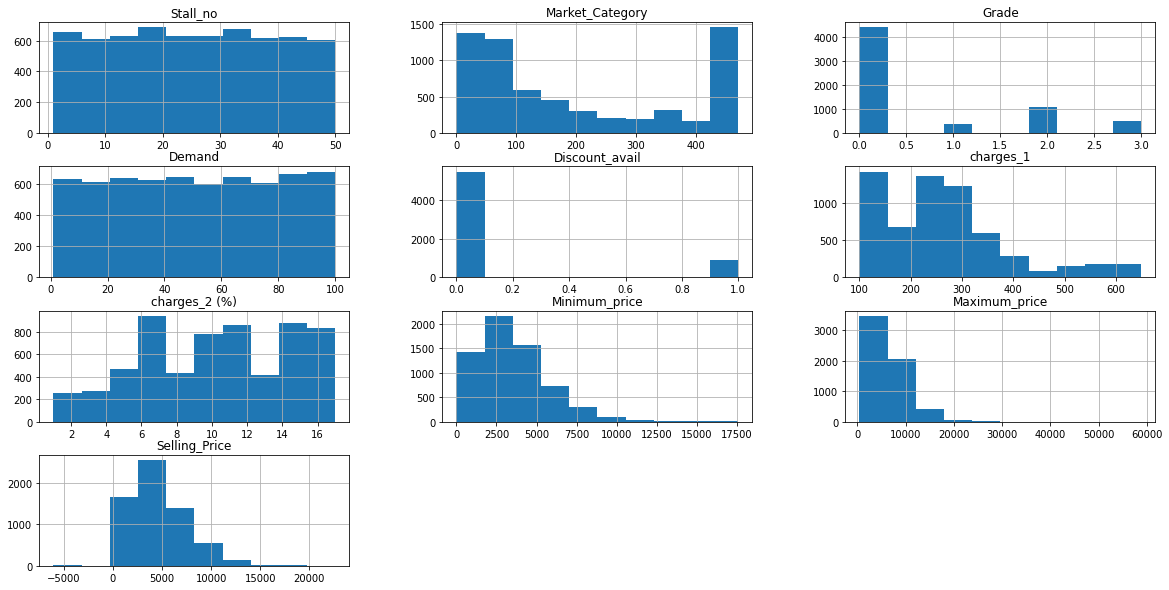

In [ ]:
train_df.hist(figsize=(20, 10));
plt.show()

In [ ]:
train_df.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,4185.947700
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,9271.490256
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,6785.701362
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,13028.917824
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,906.553935


In [ ]:
train_df.nunique()

Product_id          6368
Stall_no              50
instock_date        5350
Market_Category      248
Customer_name       5900
Loyalty_customer       2
Product_Category      10
Grade                  4
Demand               100
Discount_avail         2
charges_1            487
charges_2 (%)         17
Minimum_price       4236
Maximum_price       4618
Selling_Price       6321
dtype: int64

# Evaluator

In [ ]:
def evaluator(y_pred, y_label):
    return max(0, 100- np.sqrt(mean_squared_log_error( y_label, np.abs(y_pred) )) )

# EDA#1

## Concatatenating train_df and test_df

In [ ]:
split = train_df.shape[0]
labels = train_df['Selling_Price']
features = train_df.iloc[:,:-1]
tntt_features = pd.concat([features, test_df], axis = 0)
tntt_features.shape

(9798, 14)

## Separating column with null values

In [ ]:
null_cols = []; non_null_cols = []
for col in tntt_features.columns.to_list():
    if (tntt_features[col].isnull().values.any()):
        null_cols.append(col)
    else:
        non_null_cols.append(col)

print('Null Columns are :')
print(null_cols)
print("NON null columns are :")
print(non_null_cols)

Null Columns are :
['Stall_no', 'Customer_name', 'Discount_avail', 'charges_1', 'charges_2 (%)', 'Minimum_price', 'Maximum_price']
NON null columns are :
['Product_id', 'instock_date', 'Market_Category', 'Loyalty_customer', 'Product_Category', 'Grade', 'Demand']


## Dealing with Null values

In [ ]:
tntt_features[null_cols]

,Stall_no,Customer_name,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price
0,37.0,Lillyann,0.0,376.0,11.0,2983.0,4713.0
1,38.0,Klynn,0.0,397.0,12.0,7495.0,10352.0
2,9.0,Ridge,0.0,250.0,9.0,5752.0,7309.0
3,50.0,Abran,0.0,144.0,13.0,5090.0,20814.0
4,7.0,Dustyn,1.0,211.0,4.0,2430.0,9261.0
...,...,...,...,...,...,...,...
3425,9.0,Davion,0.0,117.0,5.0,3094.0,4674.0
3426,30.0,Maiah,0.0,509.0,6.0,3384.0,14105.0
3427,14.0,Gwendolen,0.0,150.0,17.0,710.0,10894.0
3428,1.0,Addilynn,0.0,325.0,15.0,1477.0,5165.0


### Stall_no

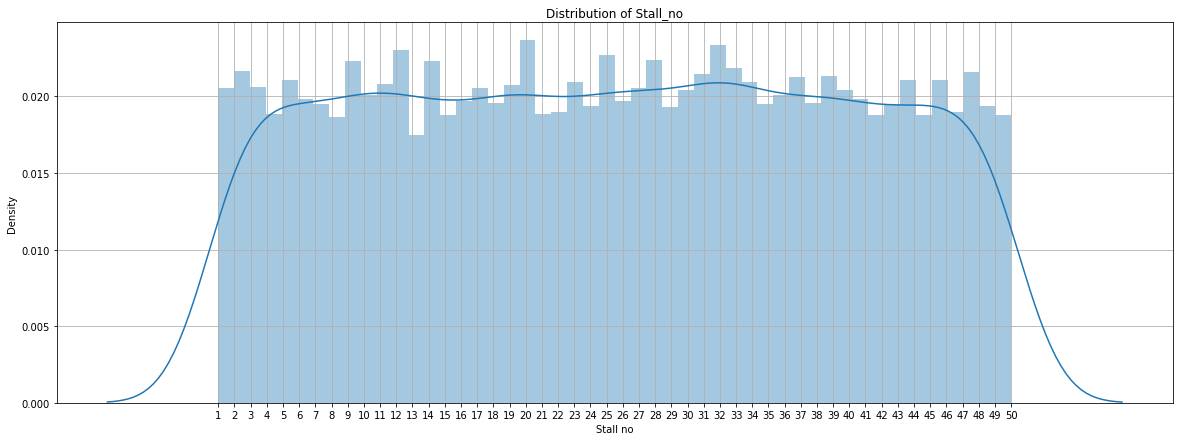

In [ ]:
plt.figure(figsize=(20,7))
sns.distplot(tntt_features.Stall_no.values, bins=50)
plt.title('Distribution of Stall_no')
plt.xlabel('Stall no')
plt.xticks([i for i in range(1,51)])
plt.grid()
plt.show();

In [ ]:
tntt_features.Stall_no.nunique()

50

In [ ]:
tntt_features.Stall_no.isnull().values.sum()

6

In [ ]:
tntt_features.Stall_no.fillna(-999, inplace = True)

In [ ]:
tntt_features['Stall_no_null'] = tntt_features.Stall_no.apply(lambda x: 1 if (x==-999) else 0)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null
3393,NKCE9Q93CUEMGS46,9.0,2015-11-17 05:36:00.000,452,Gretta,No,Pet_care,0,32,0.0,181.0,8.0,4108.0,5905.0,0
3564,TOPE5W325WWQFR3B,19.0,2016-03-30 20:52:13.000,358,Tyleah,No,Hospitality,3,67,0.0,283.0,8.0,1681.0,18681.0,0


In [ ]:
tntt_features['Stall_no_null'].nunique()

2

In [ ]:
tntt_features['Stall_no'] = tntt_features['Stall_no'].replace(-999, value=tntt_features['Stall_no'].mode().values[0])

### Customer_name

In [ ]:
tntt_features.Customer_name.nunique()

8959

In [ ]:
tntt_features.Customer_name.value_counts()

Ramsey       2
Quin         2
Channing     2
Winter       2
Arley        2
            ..
Vansh        1
Vittorio     1
Aniah        1
Charlotte    1
Novalynn     1
Name: Customer_name, Length: 8959, dtype: int64

In [ ]:
test_df.Customer_name.isnull().values.sum()

53

In [ ]:
tntt_features.Customer_name.fillna('UNKNOWN', inplace = True)
tntt_features['Customer_name_null'] = tntt_features.Customer_name.apply(lambda x: 1 if (x=='UNKNOWN') else 0)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null
6057,PTPEB98UCDYJ2MTE,8.0,2015-10-05 21:02:11.000,441,Ailin,No,Home_decor,0,97,1.0,225.0,14.0,3460.0,4776.0,0,0
3221,NKCE845VFGMPFFMT,44.0,2015-11-19 05:55:06.000,152,Kendal,No,Home_decor,0,91,0.0,206.0,16.0,7808.0,10470.0,0,0


In [ ]:
freq_encode_cus_name = tntt_features.groupby('Customer_name').size()
tntt_features['Customer_buy_freq'] = tntt_features.Customer_name.map(freq_encode_cus_name )
tntt_features.sample(3)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq
3368,SNDE9GYPHPHJZXB7,44.0,2016-03-20 19:02:15.000,2,Paradise,Yes,Repair,1,89,0.0,280.0,3.0,6922.0,8363.0,0,0,1
3691,NKCEB3XAKJ6XEJQE,39.0,2016-01-06 05:30:46.000,268,Jax,No,Child_care,2,77,0.0,256.0,12.0,940.0,3253.0,0,0,2
2991,TUNEHU6D7SFN7SYY,46.0,2015-08-23 11:25:07.000,447,Eleazar,No,Cosmetics,0,54,0.0,280.0,15.0,4697.0,6515.0,0,0,1


### Discount_avail

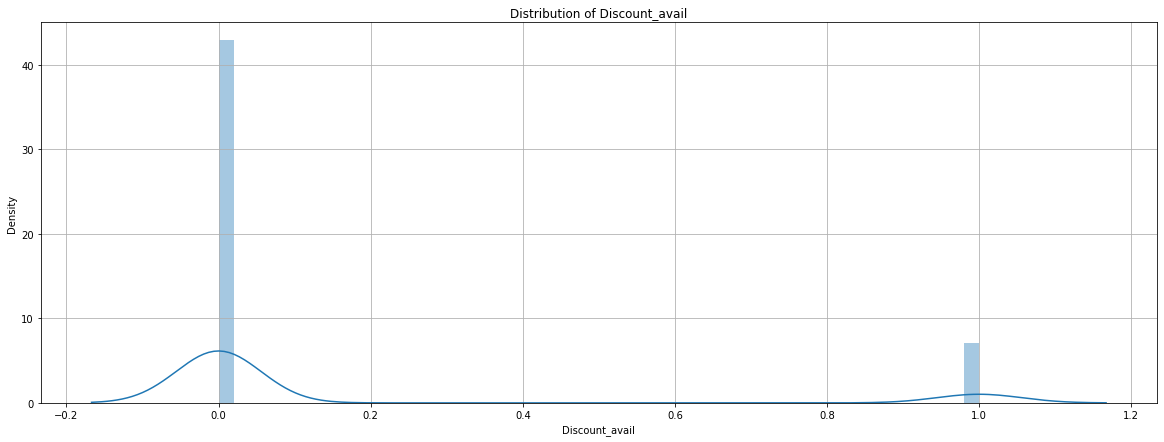

In [ ]:
plt.figure(figsize=(20,7))
sns.distplot(tntt_features.Discount_avail.values)
plt.title('Distribution of Discount_avail')
plt.xlabel('Discount_avail')

plt.grid()
plt.show();

In [ ]:
tntt_features.Discount_avail.fillna(-999, inplace = True)
tntt_features['Discount_avail_null'] = tntt_features.Discount_avail.apply(lambda x: 1 if (x==-999) else 0)

tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null
4606,LJGEJQSBCGUWUSTW,46.0,2015-05-08 17:22:20.000,275,Jakob,Yes,Technology,0,84,0.0,636.0,6.0,3985.0,5228.0,0,0,1,0
4703,SHIEBZ9Z6247XWQG,10.0,2015-09-25 16:23:15.000,121,Jeter,Yes,Pet_care,0,66,0.0,178.0,4.0,1891.0,NaN,0,0,1,0


In [ ]:
tntt_features.Discount_avail.replace(-999, 0, inplace=True)

In [ ]:
freq_encode_discount_avail = tntt_features.groupby('Discount_avail').size()
freq_encode_discount_avail = freq_encode_discount_avail/len(tntt_features)
tntt_features['freq_encode_discount_avail'] = tntt_features.Discount_avail.map(freq_encode_discount_avail)
tntt_features.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,0,0,1,0,0.858032
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,0,0,1,0,0.858032
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,1,0,0.858032
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,0,0,1,0,0.858032
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,0,0,1,0,0.141968


In [ ]:
tntt_features.Discount_avail.isnull().values.sum()

0

### charges_1

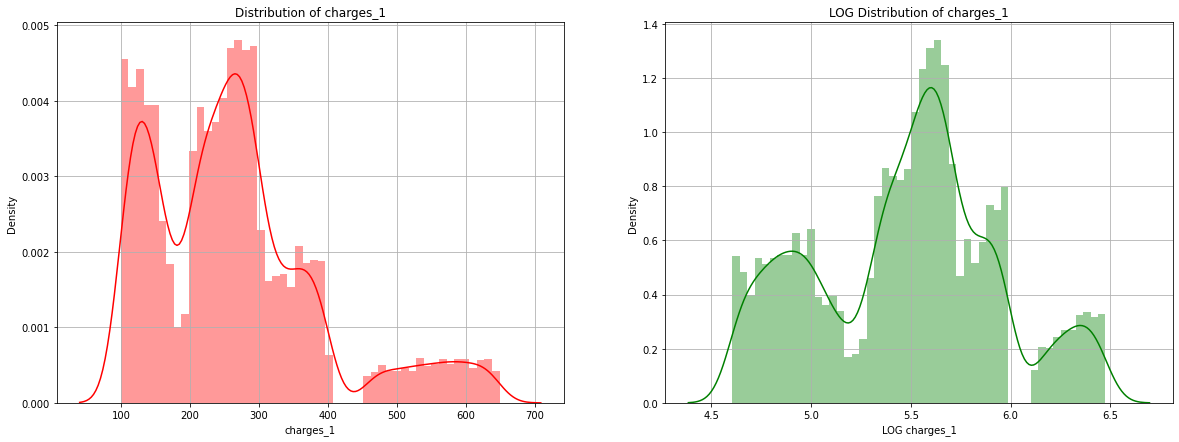

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,7))
sns.distplot(tntt_features.charges_1.values, bins=50, color='r',ax=axs[0])
sns.distplot(np.log(tntt_features.charges_1).values, bins=50, color='g', ax=axs[1])

axs[0].set_title('Distribution of charges_1')
axs[0].set_xlabel('charges_1')
axs[0].grid()

axs[1].set_title('LOG Distribution of charges_1')
axs[1].set_xlabel('LOG charges_1')
axs[1].grid()

plt.show();

In [ ]:
tntt_features.charges_1.isnull().values.sum()

234

In [ ]:
tntt_features.charges_1.fillna(-999, inplace = True)
tntt_features['charges_1_null'] = tntt_features.charges_1.apply(lambda x: 1 if (x==-999) else 0)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null
2475,SCHE5Z57GQMEGQVF,43.0,2015-11-19 03:54:24.000,358,Kareena,No,Pet_care,3,50,0.0,167.0,NaN,5590.0,14724.0,0,0,1,0,0.858032,0
756,ACBECFGTHYEUNK4C,40.0,2015-05-07 15:09:22.000,73,Aden,No,Pet_care,0,20,0.0,182.0,10.0,1061.0,1575.0,0,0,1,0,0.858032,0


In [ ]:
tntt_features.charges_1.replace(-999, tntt_features.charges_1.mean(), inplace=True)

In [ ]:
tntt_features.charges_1.quantile([(i+.5)/10 for i in range(1,10)])

0.15    135.00
0.25    165.00
0.35    215.00
0.45    235.65
0.55    260.00
0.65    283.00
0.75    311.75
0.85    371.00
0.95    553.15
Name: charges_1, dtype: float64

[INFO] From the graphs and qunatile measures it is observed that above 85% quantile values are above 500 or close to it. We can make a new column that speaks about this distribution

In [ ]:
print(f"90th quantile value : {tntt_features.charges_1.quantile([.9]).values[0]}")
print(f"91th quantile value : {tntt_features.charges_1.quantile([.91]).values[0]}")
print(f"92th quantile value : {tntt_features.charges_1.quantile([.2]).values[0]}")


90th quantile value : 397.0
91th quantile value : 466.0
92th quantile value : 147.0


In [ ]:
tntt_features['charges_1_90th_quantile'] = tntt_features.charges_1.apply(lambda x: 1 if (x>397) else 0)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile
284,ACCEKFVVZJMTYWPK,50.0,2015-05-08 13:20:08.000,58,UNKNOWN,Yes,Hospitality,1,98,0.0,202.0,12.0,3178.0,4065.0,0,1,264,0,0.858032,0,0
5284,CRTECN2QVWJWMJ9B,41.0,2015-09-24 13:27:08.000,13,Jalynn,No,Cosmetics,3,100,0.0,251.0,14.0,398.0,2143.0,0,0,1,0,0.858032,0,0


[INFO] Lets apply ranking

In [ ]:
tntt_features['ranked_charges_1'] = scipy.stats.rankdata(tntt_features.charges_1.values)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1
426,SMCEJV6XD3WH3NBN,29.0,2015-07-24 02:55:44.000,447,Estrella,Yes,Organic,0,97,0.0,147.0,6.0,4845.0,6179.0,0,0,1,0,0.858032,0,0,1970.5
1682,PBXED9Q2MZEQWXCP,20.0,2015-11-19 06:56:28.000,358,Lakota,Yes,Home_decor,3,8,0.0,290.0,12.0,5466.0,15699.0,0,0,2,0,0.858032,0,0,6715.0


[INFO] log transform and power transform

In [ ]:
tntt_features['log_charges_1'] = np.log(tntt_features.charges_1.values)
tntt_features['power_transform_charges_1'] = np.sqrt(np.add(tntt_features.charges_1.values, 2/3))

### charges_2 %

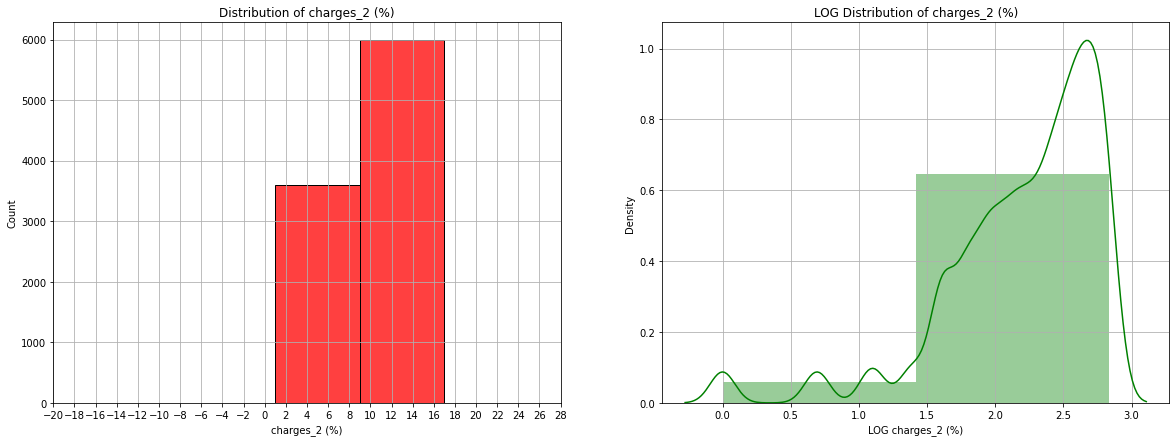

In [ ]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20,7))
sns.histplot(tntt_features['charges_2 (%)'].values, bins=2, color='r',ax=axs[0])
sns.distplot(np.log(tntt_features['charges_2 (%)']).values, bins=2, color='g', ax=axs[1])

axs[0].set_title('Distribution of charges_2 (%)')
axs[0].set_xlabel('charges_2 (%)')
axs[0].set_xticks([i for i in range(-20,30,2)])
axs[0].grid()

axs[1].set_title('LOG Distribution of charges_2 (%)')
axs[1].set_xlabel('LOG charges_2 (%)')
axs[1].grid()

plt.show();

In [ ]:
tntt_features['charges_2 (%)'].isnull().values.sum()

210

In [ ]:
tntt_features['charges_2 (%)'].fillna(-999, inplace = True)
tntt_features['charges_2 (%)_null'] = tntt_features['charges_2 (%)'].apply(lambda x: 1 if (x==-999) else 0)
tntt_features['charges_2 (%)'].replace(-999, tntt_features['charges_2 (%)'].mean(), inplace=True)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null
1682,MUGEACY7ZZV9QVBZ,46.0,2015-09-22 17:26:53.000,283,UNKNOWN,Yes,Hospitality,0,23,0.0,333.0,8.0,1016.0,4197.0,0,1,264,0,0.858032,0,0,7686.5,5.808142,18.266545,0
2295,CRTECN2QZMHEU2J3,12.0,2015-09-24 15:27:55.000,358,Kelsi,No,Technology,3,87,0.0,530.0,13.0,3203.0,10483.0,0,0,1,0,0.858032,0,1,9194.0,6.272877,23.036203,0


In [ ]:
tntt_features['ranked_charges_2'] = scipy.stats.rankdata(tntt_features['charges_2 (%)'].values)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2
5088,WATDPV5TVAPYZCJA,15.0,2016-03-28 21:40:08.000,230,Safiyyah,Yes,Home_decor,0,50,0.0,284.0,10.0,7990.0,11251.0,0,0,1,0,0.858032,0,0,6442.0,5.648974,16.872068,0,4774.5
5896,SFFEG763F38URMXA,2.0,2016-03-29 20:56:42.000,83,Alissandra,Yes,Educational,1,31,0.0,147.0,9.0,4391.0,10295.0,0,0,1,0,0.858032,0,0,1970.5,4.990433,12.151817,0,4159.0


In [ ]:
tntt_features['charges_2 (%)'].isnull().values.sum()

0

In [ ]:
tntt_features['log_charges_2'] = np.log(np.add(np.abs(tntt_features['charges_2 (%)'].values), 1))
tntt_features['power_transform_charge_2'] = np.sqrt(np.add(np.abs(tntt_features['charges_2 (%)'].values), 2/3))

[INFO] I believe there may be hidden feature total charges but, I am not sure how I can get it, so I will simple scale my charges_2 values and add it to charges_1 values

In [ ]:
tntt_features['total_charges'] = tntt_features['charges_1'] + 100*tntt_features['charges_2 (%)']
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges
736,BRAEB2S8XHF9P96G,17.0,2015-08-19 18:36:50.000,447,Rayyan,Yes,Cosmetics,0,86,0.0,281.0,14.0,5609.0,7896.0,0,0,1,0,0.858032,0,0,6300.5,5.638355,16.782928,0,7471.5,2.708050,3.829708,1681.0
2253,NKCE8HVPP6NNZHVC,7.0,2015-09-24 14:26:43.000,23,Jaxston,No,Pet_care,2,35,0.0,192.0,3.0,2372.0,11327.0,0,0,1,0,0.858032,0,0,2809.5,5.257495,13.880442,0,701.0,1.386294,1.914854,492.0


### Minimun and Maximum prices

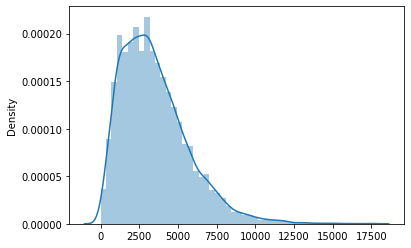

In [ ]:
sns.distplot(tntt_features['Minimum_price'].values)

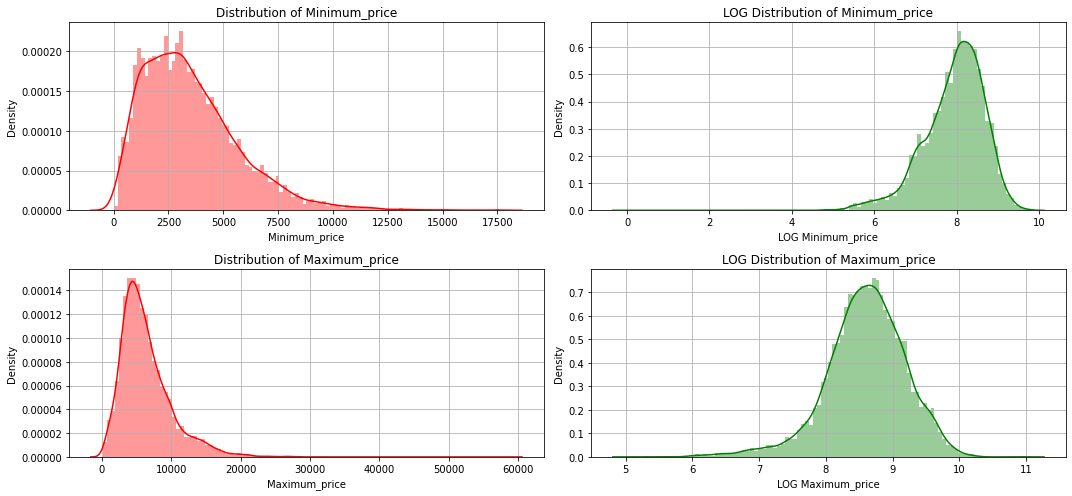

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,7))
sns.distplot(tntt_features['Minimum_price'].values, bins=100, color='r',ax=axs[0][0])
sns.distplot(np.log(tntt_features['Minimum_price']).values, bins=100, color='g', ax=axs[0][1])
sns.distplot(tntt_features['Maximum_price'].values, bins=100, color='r',ax=axs[1][0])
sns.distplot(np.log(tntt_features['Maximum_price']).values, bins=100, color='g', ax=axs[1][1])

axs[0][0].set_title('Distribution of Minimum_price')
axs[0][0].set_xlabel('Minimum_price')
# axs[0][0].set_xticks([i for i in range(-20,30,2)])
axs[0][0].grid()

axs[0][1].set_title('LOG Distribution of Minimum_price')
axs[0][1].set_xlabel('LOG Minimum_price')
axs[0][1].grid()

axs[1][0].set_title('Distribution of Maximum_price')
axs[1][0].set_xlabel('Maximum_price')
# axs[1][0].set_xticks([i for i in range(-22,32,2)])
axs[1][0].grid()

axs[1][1].set_title('LOG Distribution of Maximum_price')
axs[1][1].set_xlabel('LOG Maximum_price')
axs[1][1].grid()


plt.tight_layout()
plt.show();

In [ ]:
tntt_features['Minimum_price'].fillna(-999, inplace = True)
tntt_features['Minimum_price_null'] = tntt_features['Minimum_price'].apply(lambda x: 1 if (x==-999) else 0)
tntt_features['Minimum_price'].replace(-999, tntt_features['Minimum_price'].mean(), inplace=True)

tntt_features['Maximum_price'].fillna(-999, inplace = True)
tntt_features['Maximum_price_null'] = tntt_features['Maximum_price'].apply(lambda x: 1 if (x==-999) else 0)
tntt_features['Maximum_price'].replace(-999, tntt_features['Maximum_price'].mean(), inplace=True)

tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null
4795,TOPECDETUGGJHVZC,5.0,2015-08-22 19:32:50.000,39,Keelan,Yes,Cosmetics,3,76,0.0,292.0,13.0,3724.0,9365.0,0,0,1,0,0.858032,0,0,6807.5,5.676754,17.107503,0,6740.0,2.639057,3.696846,1592.0,0,0
1024,JCKEEB5YX5Q8HYBM,38.0,2016-03-30 20:58:03.000,49,Broxton,No,Repair,2,36,0.0,267.0,1.0,1182.0,3091.0,0,0,1,0,0.858032,0,0,5701.0,5.587249,16.360522,0,306.5,0.693147,1.290994,367.0,0,0


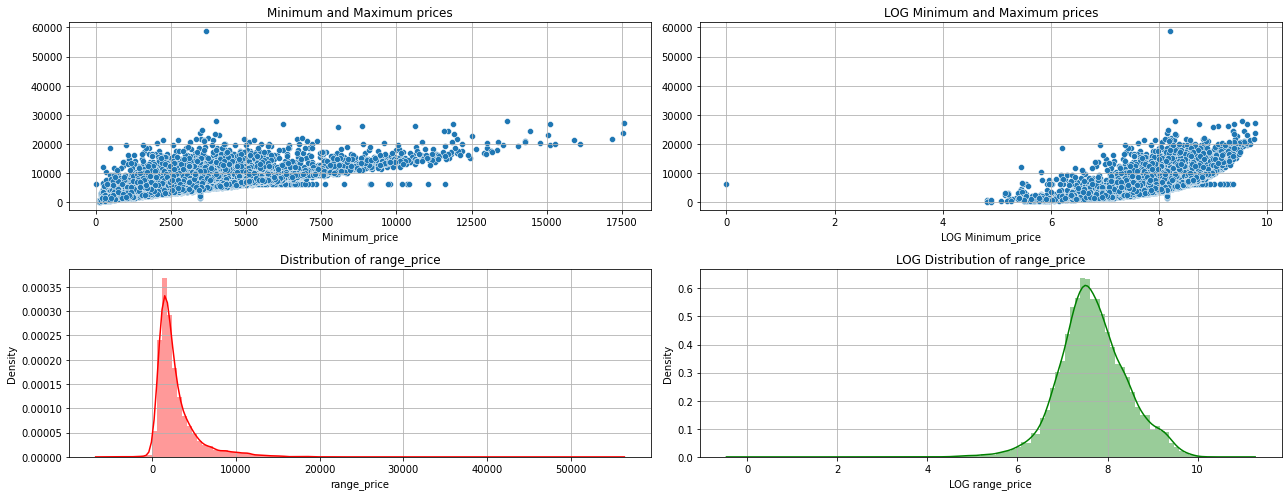

In [ ]:
tntt_features['range_price'] = tntt_features['Maximum_price'] - tntt_features["Minimum_price"]


fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (18,7))
sns.scatterplot(x = tntt_features['Minimum_price'].values, y = tntt_features['Maximum_price'].values, ax=axs[0][0])
sns.scatterplot(x = np.log(tntt_features['Minimum_price']).values, y = tntt_features['Maximum_price'].values, ax=axs[0][1])
sns.distplot(tntt_features['range_price'].values, bins=100, color='r',ax=axs[1][0])
sns.distplot(np.log(tntt_features['range_price']).values, bins=100, color='g', ax=axs[1][1])

axs[0][0].set_title('Minimum and Maximum prices')
axs[0][0].set_xlabel('Minimum_price')
# axs[0][0].set_xticks([i for i in range(-20,30,2)])
axs[0][0].grid()

axs[0][1].set_title('LOG Minimum and Maximum prices')
axs[0][1].set_xlabel('LOG Minimum_price')
axs[0][1].grid()

axs[1][0].set_title('Distribution of range_price')
axs[1][0].set_xlabel('range_price')
# axs[1][0].set_xticks([i for i in range(-22,32,2)])
axs[1][0].grid()

axs[1][1].set_title('LOG Distribution of range_price')
axs[1][1].set_xlabel('LOG range_price')
axs[1][1].grid()


plt.tight_layout()
plt.show();

In [ ]:
tntt_features['ranked_Minimum_price'] = scipy.stats.rankdata(tntt_features['Minimum_price'].values)
tntt_features['ranked_Maximum_price'] = scipy.stats.rankdata(tntt_features['Maximum_price'].values)
tntt_features['ranked_range_price'] = scipy.stats.rankdata(tntt_features['range_price'].values)

## Dealing with NON_null_Columns

In [ ]:
tntt_features[non_null_cols]

,Product_id,instock_date,Market_Category,Loyalty_customer,Product_Category,Grade,Demand
0,BRAE2NF6JA5GUEXG,2015-08-22 18:36:12.000,2,Yes,Fashion,1,68
1,TUNE8SFB6RJN2HSD,2016-03-27 21:19:13.000,24,Yes,Fashion,0,51
2,BRAEAR7WZPQGPBZU,2015-08-18 19:25:22.000,447,Yes,Child_care,0,10
3,WATDZ2ZQ8JPDHCTJ,2016-03-28 21:53:01.000,23,Yes,Educational,2,48
4,JWSEBUKYQPMBZ3RK,2016-03-29 22:58:53.000,63,Yes,Repair,1,35
...,...,...,...,...,...,...,...
3425,BBAE9K7BXFUTDNBK,2015-08-15 21:17:17.000,58,Yes,Pet_care,0,39
3426,RTRDYPA4PJHCJCGF,2015-12-04 01:51:47.000,358,Yes,Technology,3,17
3427,TUNE8FWQBS7TVVT7,2016-03-28 20:55:47.000,106,Yes,Educational,0,36
3428,NKCEGMUABCRGUZPE,2015-05-23 07:41:36.000,104,Yes,Child_care,0,63


### Loyalty_customer

In [ ]:
fig = px.histogram(tntt_features, x = 'Loyalty_customer', color='Loyalty_customer')

layouts = ({"title":"Distribution of Loyalty_Customer", 
            "title_x":0.5,
            "yaxis": {"title":"Count"},
            "xaxis": {"title":"Loyalty", 'categoryorder':'total descending'},
            })
fig.update_layout(layouts)
fig.show();

In [ ]:
len(tntt_features)

9798

In [ ]:
freq_encode_loyalty = tntt_features.groupby('Loyalty_customer').size()
freq_encode_loyalty = freq_encode_loyalty/len(tntt_features)
tntt_features['freq_encode_loyalty'] = tntt_features.Loyalty_customer.map(freq_encode_loyalty)
tntt_features.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12.000,2,Lillyann,Yes,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,0,0,1,0,0.858032,0,0,8428.0,5.929589,19.407902,0,5379.0,2.484907,3.415650,1476.0,0,0,1730.0,4580.5,3591.0,3819.5,0.609716
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13.000,24,Klynn,Yes,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,0,0,1,0,0.858032,0,0,8809.5,5.983936,19.941581,0,6055.5,2.564949,3.559026,1597.0,0,0,2857.0,9289.5,8649.0,6627.5,0.609716
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22.000,447,Ridge,Yes,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,1,0,0.858032,0,0,4907.5,5.521461,15.832456,0,4159.0,2.302585,3.109126,1150.0,0,0,1557.0,8418.5,6912.5,3211.5,0.609716
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01.000,23,Abran,Yes,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,0,0,1,0,0.858032,0,0,1824.0,4.969813,12.027746,0,6740.0,2.639057,3.696846,1444.0,0,0,15724.0,7834.0,9757.0,9768.0,0.609716
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53.000,63,Dustyn,Yes,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,0,0,1,0,0.141968,0,0,3285.0,5.351858,14.548769,0,909.0,1.609438,2.160247,611.0,0,0,6831.0,3534.0,8159.5,9087.0,0.609716


In [ ]:
loyal_C_encode = LabelEncoder()
tntt_features.Loyalty_customer = loyal_C_encode.fit_transform(tntt_features.Loyalty_customer)
loyal_C_encode.classes_

array(['No ', 'Yes'], dtype=object)

### instock_date

In [ ]:
tntt_features['instock_date'] = pd.to_datetime(tntt_features['instock_date'])

tntt_features.loc[:, 'year'] = tntt_features.instock_date.dt.year
tntt_features.loc[:, 'weekofyear'] = tntt_features.instock_date.dt.weekofyear
tntt_features.loc[:, 'month'] = tntt_features.instock_date.dt.month
tntt_features.loc[:, 'dayofweek'] = tntt_features.instock_date.dt.dayofweek
tntt_features.loc[:, 'day'] = tntt_features.instock_date.dt.day
tntt_features.loc[:, 'weekend'] = (tntt_features.instock_date.dt.weekday>=5).astype('int')
tntt_features.loc[:, 'hour'] = tntt_features.instock_date.dt.hour
tntt_features.loc[:, 'minutes'] = tntt_features.instock_date.dt.minute
tntt_features.loc[:, 'seconds'] = tntt_features.instock_date.dt.second

tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds
3594,HMBEJCMHHYWQZKYF,45.0,2015-08-22 20:47:26,236,Dereck,0,Repair,0,48,0.0,280.0,7.0,1152.0,5983.0,0,0,1,0,0.858032,0,0,6255.5,5.634790,16.753109,0,2757.5,2.079442,2.768875,980.0,0,0,4831.0,1114.0,5223.0,8448.0,0.390284,2015,34,8,5,22,1,20,47,26
18,BRAE8WYH2TFGZAQG,14.0,2015-08-19 20:37:05,294,Tristin,0,Hospitality,2,29,0.0,273.0,9.0,1876.0,4092.0,0,0,2,0,0.858032,0,0,5975.5,5.609472,16.542874,0,4159.0,2.302585,3.109126,1173.0,0,0,2216.0,2461.0,2661.0,5310.5,0.390284,2015,34,8,2,19,0,20,37,5


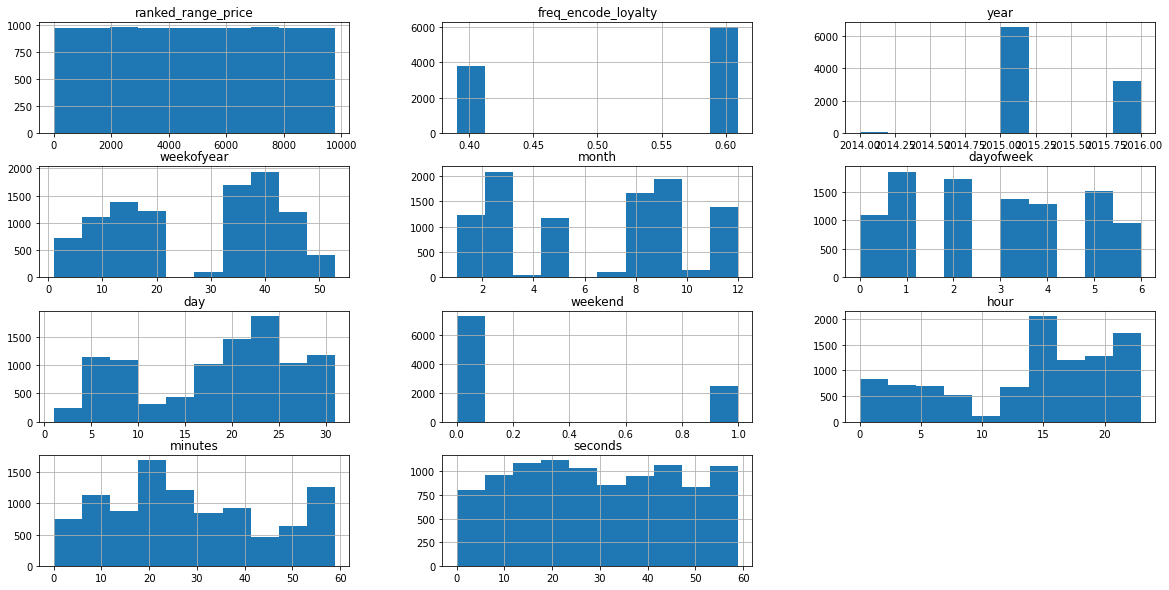

In [ ]:
tntt_features.iloc[:, -11:].hist(figsize = (20, 10));

[INFO] Selling is usually high around 5-10 days and between 20-25 days left for halloween

[INFO] We can see that in **year**, 2014 is having the least peak

In [ ]:
year_fig = px.histogram(tntt_features, x = 'year', color = 'year', title = 'YEAR')
year_fig.show();

In [ ]:
train_df.loc[:, "Date"] = train_df.instock_date.apply(lambda x: x.split()[0])
train_df.loc[:, "Time"] = train_df.instock_date.apply(lambda x: x.split()[1])

train_df.loc[:, "Date"] = pd.to_datetime(train_df.loc[:, "Date"])
train_df.loc[:, 'year'] = train_df.Date.dt.year

print(f"# Null values in selling price while year == 2014 : {train_df.loc[train_df.year == 2014].Selling_Price.isnull().values.sum()}")

# Null values in selling price while year == 2014 : 1


[INFO] We know that Halloween occurs in 31st of OCT


*   day = 31
*   month = 10

Lets generate a features that will say # of days left until halloween


In [ ]:
year_fig = px.histogram(tntt_features, x = 'day', color = 'year', title = 'day')

layouts = ({"title":"Distribution of day", 
            "title_x":0.5,
            "yaxis": {"title":"Count"},
            "xaxis": {"title":"Day", 'categoryorder':'total descending'},
            })

year_fig.update_layout(layouts)
year_fig.show();

In [ ]:
tntt_features.loc[:, 'days_left'] = tntt_features.day.apply(lambda x: 31-x)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left
6056,BRAE2NF6YG24FGDW,46.0,2015-08-20 20:37:07,456,Adolfo,0,Repair,0,67,0.0,225.0,6.0,448.0,1867.0,0,0,1,0,0.858032,0,0,3806.0,5.416100,15.022206,0,2035.5,1.945910,2.581989,825.0,0,0,1419.0,207.0,430.5,2698.5,0.390284,2015,34,8,3,20,0,20,37,7,11
1303,SNDEGJFVJAHQCENF,6.0,2016-03-29 19:49:26,358,Avner,0,Home_decor,3,1,0.0,243.0,11.0,5179.0,16790.0,0,0,1,0,0.858032,0,0,4669.5,5.493061,15.609826,0,5379.0,2.484907,3.415650,1343.0,0,0,11611.0,7924.5,9640.0,9647.0,0.390284,2016,13,3,1,29,0,19,49,26,2


In [ ]:
tntt_features.loc[:, "12_24"] = tntt_features.hour.apply(lambda x : 12 if (x<12) else 24)
tntt_features.sample(2)

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left,12_24
5267,NKCE88AHRYCG8JUV,6.0,2015-09-24 16:26:37,152,Westen,0,Technology,0,62,0.0,533.0,7.0,1698.0,2254.0,0,0,1,0,0.858032,0,1,9210.5,6.278521,23.101227,0,2757.5,2.079442,2.768875,1233.0,0,0,556.0,2107.0,646.0,358.0,0.390284,2015,39,9,3,24,0,16,26,37,7,24
513,JCKEEABZDWF9VU7N,26.0,2016-03-30 20:57:04,65,Baltazar,0,Cosmetics,2,86,0.0,294.0,12.0,5339.0,8461.0,0,0,1,0,0.858032,0,0,6901.0,5.683580,17.165858,0,6055.5,2.564949,3.559026,1494.0,0,0,3122.0,8084.5,7734.5,7026.0,0.390284,2016,13,3,2,30,0,20,57,4,1,24


Understanding the behaviour of Mr.X. He/She has been a Loyal_Customer from Nov 2014 to 2015

In [ ]:
tntt_features.loc[(tntt_features.Customer_name=='UNKNOWN') & (tntt_features.Loyalty_customer==1)].year.unique()

array([2015, 2014])

In [ ]:
tntt_features.loc[(tntt_features.Customer_name=='UNKNOWN') & (tntt_features.Loyalty_customer==1) & (tntt_features.year==2014)]

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left,12_24
3021,KTAEHE9H9MVK42JA,35.0,2014-11-08 17:15:45,23,UNKNOWN,1,Home_decor,2,3,0.0,282.0,17.0,4819.0,11778.0,0,1,264,0,0.858032,0,0,6342.0,5.641907,16.812694,0,9477.5,2.890372,4.203173,1982.0,0,0,6959.0,7546.0,9006.0,9114.0,0.609716,2014,45,11,5,8,1,17,15,45,23,24


In [ ]:
tntt_features.loc[(tntt_features.Customer_name=='UNKNOWN') & (tntt_features.Loyalty_customer==1)].Discount_avail.unique()

array([0., 1.])

In [ ]:
tntt_features.loc[(tntt_features.Customer_name=='UNKNOWN') & (tntt_features.Discount_avail==0)  & (tntt_features.year==2014)]

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left,12_24
1081,SHOEGVQCT2ZSGUHY,45.0,2014-11-01 11:30:23,268,UNKNOWN,0,Educational,2,96,0.0,148.0,8.000000,1592.0,4907.0,0,1,264,0,0.858032,0,0,2023.5,4.997212,12.192894,0,3476.0,2.197225,2.943920,948.000000,0,0,3315.0,1932.0,3859.0,7267.5,0.390284,2014,44,11,5,1,1,11,30,23,30,12
3021,KTAEHE9H9MVK42JA,35.0,2014-11-08 17:15:45,23,UNKNOWN,1,Home_decor,2,3,0.0,282.0,17.000000,4819.0,11778.0,0,1,264,0,0.858032,0,0,6342.0,5.641907,16.812694,0,9477.5,2.890372,4.203173,1982.000000,0,0,6959.0,7546.0,9006.0,9114.0,0.609716,2014,45,11,5,8,1,17,15,45,23,24
3150,TSHEHBHSKBJWHFNF,13.0,2014-10-23 03:14:32,114,UNKNOWN,0,Fashion,0,22,0.0,386.0,-11.381404,1756.0,4078.0,0,1,264,0,0.858032,0,0,8608.0,5.955837,19.663842,1,105.5,2.516196,3.471033,-752.140437,0,0,2322.0,2234.5,2637.5,5576.5,0.390284,2014,43,10,3,23,0,3,14,32,8,12


### Market Category

In [ ]:
market_C_fig = px.histogram(tntt_features, x = 'Market_Category', color = 'Market_Category')

layouts = ({"title":"Distribution of Market category", 
            "title_x":0.5,
            "yaxis": {"title":"Count"},
            "xaxis": {"title":"Market_Category", 'categoryorder':'total descending'},
            })

market_C_fig.update_layout(layouts)
market_C_fig.show();

In [ ]:
tntt_features['ranked_Market_Category'] = scipy.stats.rankdata(tntt_features['Market_Category'].values, method = 'ordinal')

### Product_Category

In [ ]:
prod_C_fig = px.histogram(tntt_features, x = 'Product_Category', color = 'Product_Category')

layouts = ({"title":"Distribution of product category", 
            "title_x":0.5,
            "yaxis": {"title":"Count"},
            "xaxis": {"title":"Product_Category", 'categoryorder':'total descending'},
            })

prod_C_fig.update_layout(layouts)
prod_C_fig.show();

In [ ]:
tntt_features['ranked_Product_Category'] = scipy.stats.rankdata(tntt_features['Product_Category'].values, method = 'ordinal')

### Grade

In [ ]:
grade_fig = px.histogram(tntt_features, x = 'Grade', color = 'Grade')

layouts = ({"title":"Distribution of Grade", 
            "title_x":0.5,
            "yaxis": {"title":"Count"},
            "xaxis": {"title":"Grade", 'categoryorder':'total ascending'},
            })

grade_fig.update_layout(layouts)
grade_fig.show();

In [ ]:
freq_encode_grade = tntt_features.groupby('Grade').size()
freq_encode_grade = freq_encode_grade/len(tntt_features)
tntt_features['freq_encode_grade'] = tntt_features.Grade.map(freq_encode_grade)
tntt_features.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left,12_24,ranked_Market_Category,ranked_Product_Category,freq_encode_grade
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12,2,Lillyann,1,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,0,0,1,0,0.858032,0,0,8428.0,5.929589,19.407902,0,5379.0,2.484907,3.415650,1476.0,0,0,1730.0,4580.5,3591.0,3819.5,0.609716,2015,34,8,5,22,1,18,36,12,9,24,122,2969,0.059298
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13,24,Klynn,1,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,0,0,1,0,0.858032,0,0,8809.5,5.983936,19.941581,0,6055.5,2.564949,3.559026,1597.0,0,0,2857.0,9289.5,8649.0,6627.5,0.609716,2016,12,3,6,27,1,21,19,13,4,24,1515,2970,0.685344
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22,447,Ridge,1,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,1,0,0.858032,0,0,4907.5,5.521461,15.832456,0,4159.0,2.302585,3.109126,1150.0,0,0,1557.0,8418.5,6912.5,3211.5,0.609716,2015,34,8,1,18,0,19,25,22,13,24,8228,1,0.685344
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01,23,Abran,1,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,0,0,1,0,0.858032,0,0,1824.0,4.969813,12.027746,0,6740.0,2.639057,3.696846,1444.0,0,0,15724.0,7834.0,9757.0,9768.0,0.609716,2016,13,3,0,28,0,21,53,1,3,24,1020,2004,0.173301
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53,63,Dustyn,1,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,0,0,1,0,0.141968,0,0,3285.0,5.351858,14.548769,0,909.0,1.609438,2.160247,611.0,0,0,6831.0,3534.0,8159.5,9087.0,0.609716,2016,13,3,1,29,0,22,58,53,2,24,3201,7818,0.059298


In [ ]:
tntt_features['ranked_Grade'] = scipy.stats.rankdata(tntt_features['Grade'].values, method = 'ordinal')

### Demand

In [ ]:
demand_fig = px.histogram(tntt_features, x = 'Demand', color = 'Demand')

layouts = ({"title":"Distribution of Demand", 
            "title_x":0.5,
            "yaxis": {"title":"Count"},
            "xaxis": {"title":"Demand", 'categoryorder':'total ascending'},
            })

demand_fig.update_layout(layouts)
demand_fig.show();

In [ ]:
tntt_features['ranked_Demand'] = scipy.stats.rankdata(tntt_features['Demand'].values)

# Data post processing

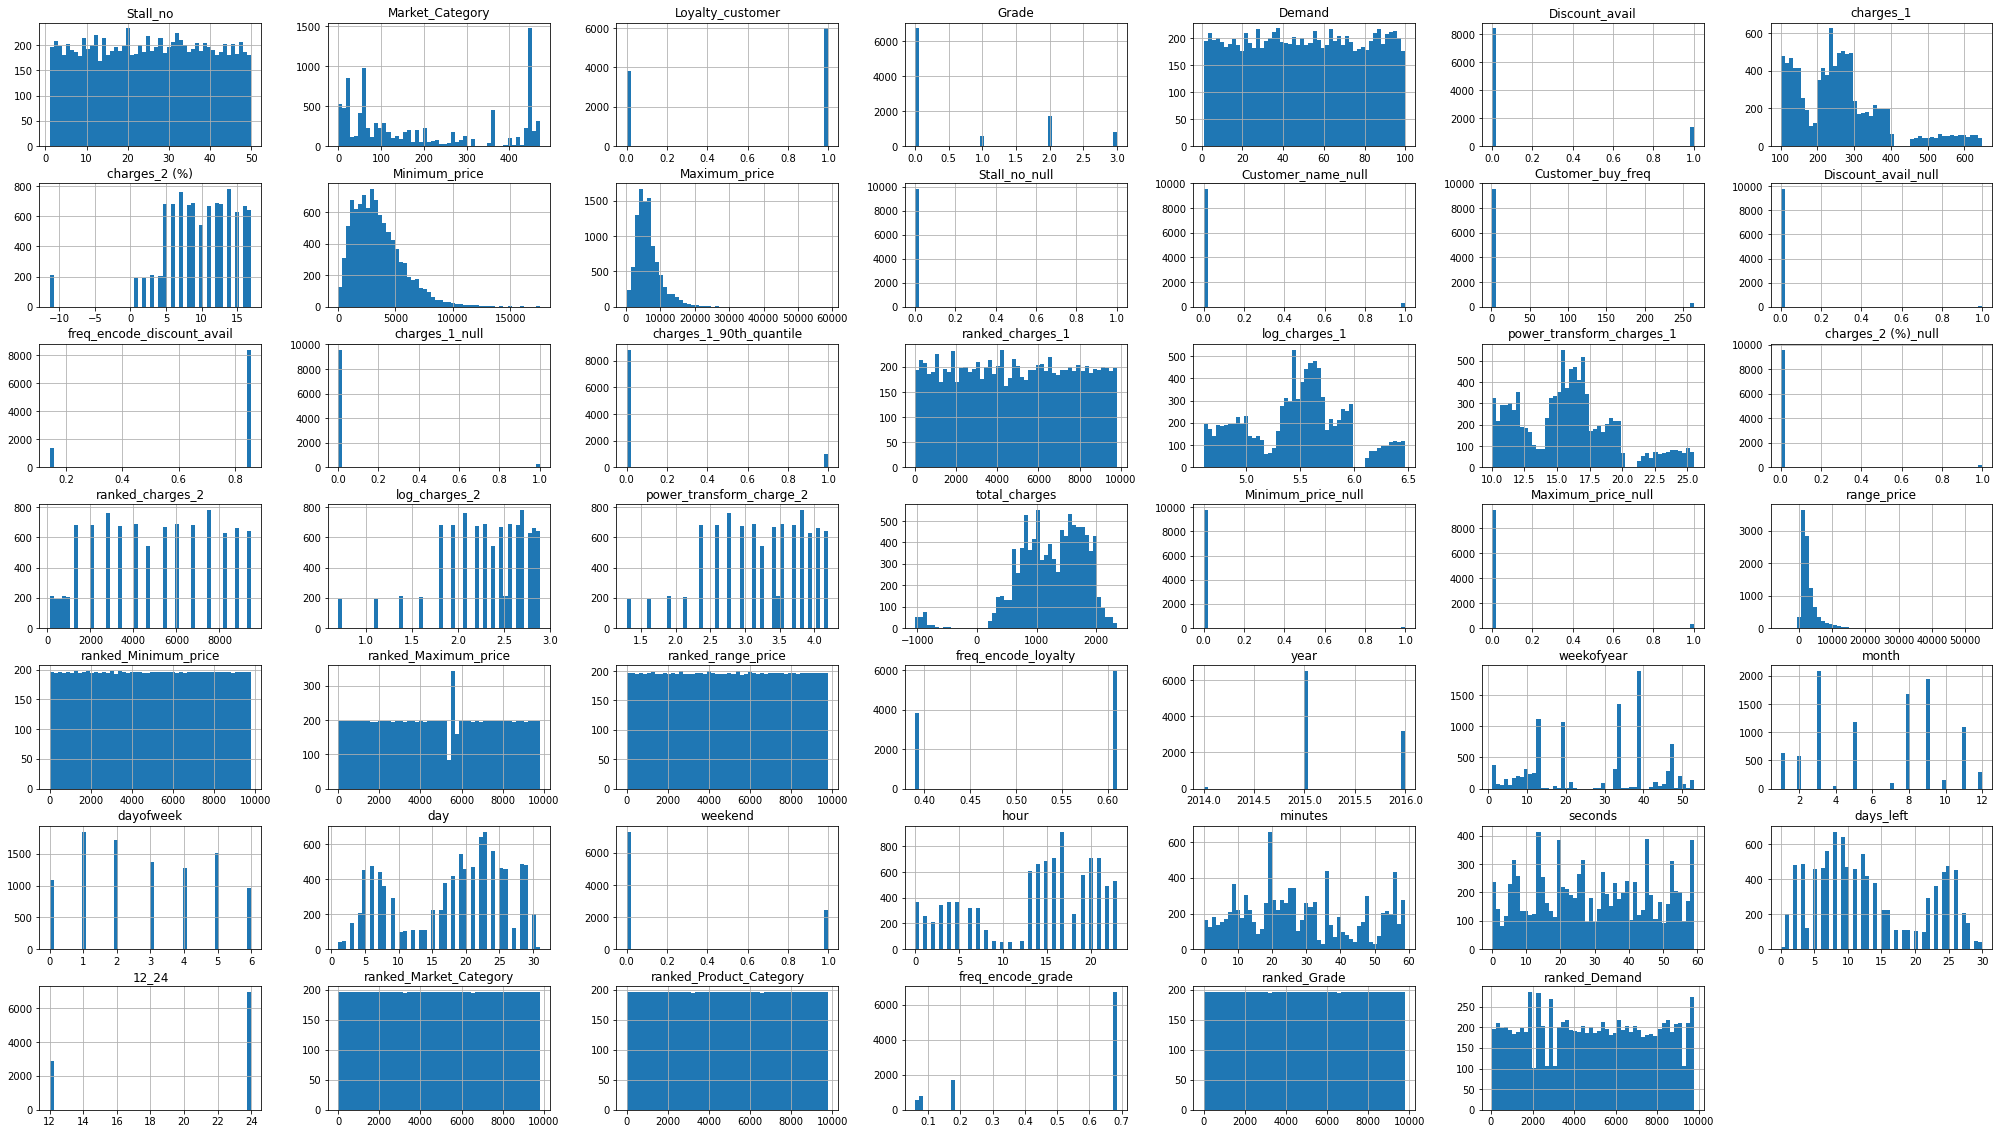

In [ ]:
tntt_features.hist(bins=50, figsize = (35,20));

In [ ]:
tntt_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9798 entries, 0 to 3429
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Product_id                  9798 non-null   object        
 1   Stall_no                    9798 non-null   float64       
 2   instock_date                9798 non-null   datetime64[ns]
 3   Market_Category             9798 non-null   int64         
 4   Customer_name               9798 non-null   object        
 5   Loyalty_customer            9798 non-null   int64         
 6   Product_Category            9798 non-null   object        
 7   Grade                       9798 non-null   int64         
 8   Demand                      9798 non-null   int64         
 9   Discount_avail              9798 non-null   float64       
 10  charges_1                   9798 non-null   float64       
 11  charges_2 (%)               9798 non-null   float64     

## Encoding our Customer_name, Product_Category

In [ ]:
cus_name_encoder = LabelEncoder()
tntt_features['Customer_name'] = cus_name_encoder.fit_transform(tntt_features.Customer_name.values)

tntt_features.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left,12_24,ranked_Market_Category,ranked_Product_Category,freq_encode_grade,ranked_Grade,ranked_Demand
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12,2,5687,1,Fashion,1,68,0.0,376.0,11.0,2983.0,4713.0,0,0,1,0,0.858032,0,0,8428.0,5.929589,19.407902,0,5379.0,2.484907,3.415650,1476.0,0,0,1730.0,4580.5,3591.0,3819.5,0.609716,2015,34,8,5,22,1,18,36,12,9,24,122,2969,0.059298,6716,6620.0
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13,24,5253,1,Fashion,0,51,0.0,397.0,12.0,7495.0,10352.0,0,0,1,0,0.858032,0,0,8809.5,5.983936,19.941581,0,6055.5,2.564949,3.559026,1597.0,0,0,2857.0,9289.5,8649.0,6627.5,0.609716,2016,12,3,6,27,1,21,19,13,4,24,1515,2970,0.685344,1,4944.5
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22,447,7334,1,Child_care,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,1,0,0.858032,0,0,4907.5,5.521461,15.832456,0,4159.0,2.302585,3.109126,1150.0,0,0,1557.0,8418.5,6912.5,3211.5,0.609716,2015,34,8,1,18,0,19,25,22,13,24,8228,1,0.685344,2,945.0
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01,23,106,1,Educational,2,48,0.0,144.0,13.0,5090.0,20814.0,0,0,1,0,0.858032,0,0,1824.0,4.969813,12.027746,0,6740.0,2.639057,3.696846,1444.0,0,0,15724.0,7834.0,9757.0,9768.0,0.609716,2016,13,3,0,28,0,21,53,1,3,24,1020,2004,0.173301,7297,4659.0
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53,63,2668,1,Repair,1,35,1.0,211.0,4.0,2430.0,9261.0,0,0,1,0,0.141968,0,0,3285.0,5.351858,14.548769,0,909.0,1.609438,2.160247,611.0,0,0,6831.0,3534.0,8159.5,9087.0,0.609716,2016,13,3,1,29,0,22,58,53,2,24,3201,7818,0.059298,6717,3362.0


In [ ]:
prod_cat_encoder = LabelEncoder()
tntt_features['Product_Category'] = prod_cat_encoder.fit_transform(tntt_features.Product_Category.values)

tntt_features.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left,12_24,ranked_Market_Category,ranked_Product_Category,freq_encode_grade,ranked_Grade,ranked_Demand
0,BRAE2NF6JA5GUEXG,37.0,2015-08-22 18:36:12,2,5687,1,3,1,68,0.0,376.0,11.0,2983.0,4713.0,0,0,1,0,0.858032,0,0,8428.0,5.929589,19.407902,0,5379.0,2.484907,3.415650,1476.0,0,0,1730.0,4580.5,3591.0,3819.5,0.609716,2015,34,8,5,22,1,18,36,12,9,24,122,2969,0.059298,6716,6620.0
1,TUNE8SFB6RJN2HSD,38.0,2016-03-27 21:19:13,24,5253,1,3,0,51,0.0,397.0,12.0,7495.0,10352.0,0,0,1,0,0.858032,0,0,8809.5,5.983936,19.941581,0,6055.5,2.564949,3.559026,1597.0,0,0,2857.0,9289.5,8649.0,6627.5,0.609716,2016,12,3,6,27,1,21,19,13,4,24,1515,2970,0.685344,1,4944.5
2,BRAEAR7WZPQGPBZU,9.0,2015-08-18 19:25:22,447,7334,1,0,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,1,0,0.858032,0,0,4907.5,5.521461,15.832456,0,4159.0,2.302585,3.109126,1150.0,0,0,1557.0,8418.5,6912.5,3211.5,0.609716,2015,34,8,1,18,0,19,25,22,13,24,8228,1,0.685344,2,945.0
3,WATDZ2ZQ8JPDHCTJ,50.0,2016-03-28 21:53:01,23,106,1,2,2,48,0.0,144.0,13.0,5090.0,20814.0,0,0,1,0,0.858032,0,0,1824.0,4.969813,12.027746,0,6740.0,2.639057,3.696846,1444.0,0,0,15724.0,7834.0,9757.0,9768.0,0.609716,2016,13,3,0,28,0,21,53,1,3,24,1020,2004,0.173301,7297,4659.0
4,JWSEBUKYQPMBZ3RK,7.0,2016-03-29 22:58:53,63,2668,1,8,1,35,1.0,211.0,4.0,2430.0,9261.0,0,0,1,0,0.141968,0,0,3285.0,5.351858,14.548769,0,909.0,1.609438,2.160247,611.0,0,0,6831.0,3534.0,8159.5,9087.0,0.609716,2016,13,3,1,29,0,22,58,53,2,24,3201,7818,0.059298,6717,3362.0


## Removing unwanted columns

In [ ]:
tntt_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9798 entries, 0 to 3429
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Product_id                  9798 non-null   object        
 1   Stall_no                    9798 non-null   float64       
 2   instock_date                9798 non-null   datetime64[ns]
 3   Market_Category             9798 non-null   int64         
 4   Customer_name               9798 non-null   int64         
 5   Loyalty_customer            9798 non-null   int64         
 6   Product_Category            9798 non-null   int64         
 7   Grade                       9798 non-null   int64         
 8   Demand                      9798 non-null   int64         
 9   Discount_avail              9798 non-null   float64       
 10  charges_1                   9798 non-null   float64       
 11  charges_2 (%)               9798 non-null   float64     

In [ ]:
remove_dtypes = ['object', 'datetime64[ns]']
cols_to_remove = []
for col in list(tntt_features.columns):
    if (tntt_features[col].dtype in remove_dtypes):
        cols_to_remove.append(col)

tntt_features.drop(cols_to_remove, axis = 1, inplace=True)
tntt_features.sample(2)

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,hour,minutes,seconds,days_left,12_24,ranked_Market_Category,ranked_Product_Category,freq_encode_grade,ranked_Grade,ranked_Demand
4288,47.0,17,1740,1,7,0,28,0.0,174.0,-11.381404,7129.0,9650.0,0,0,2,0,0.858032,0,0,2633.0,5.159055,13.216152,1,105.5,2.516196,3.471033,-964.140437,0,0,2521.0,9153.0,8353.0,6018.5,0.609716,2015,39,9,3,24,0,14,26,36,7,24,1002,7251,0.685344,2940,2679.5
3273,38.0,220,1534,1,3,0,77,0.0,356.0,14.000000,6836.0,9296.0,0,0,2,0,0.858032,0,0,8053.0,5.874931,18.885621,0,7471.5,2.708050,3.829708,1756.000000,0,0,2460.0,9032.5,8180.0,5896.5,0.609716,2016,12,3,5,26,1,21,48,0,5,24,6091,3275,0.685344,2233,7482.5


### EDA#2

### Interested columns

In [ ]:
interested_cols = ['Stall_no', 'Market_Category', 'Customer_name', 'Loyalty_customer',
       'Product_Category', 'Grade', 'Discount_avail', 'Demand',      
        'year', 'weekofyear', 'month', 'dayofweek',
       'day', 'weekend', 'hour', 'minutes', 'seconds', 'days_left', '12_24']

In [ ]:
interested_cols_Cus = [d for d in interested_cols if (d != "Customer_name") ]
interested_cols_Stno = [d for d in interested_cols if (d != "Stall_no") ]
interested_cols_mc = [d for d in interested_cols if (d != 'Market_Category') ]
interested_cols_pc = [d for d in interested_cols if (d != 'Product_Category') ]
interested_cols_Grade = [d for d in interested_cols if (d != 'Grade') ]


### Making groupbys as per the customer_name

In [ ]:
temp_Cus_sum_pattern = tntt_features.groupby(['Customer_name'])[interested_cols_Cus].sum()
temp_Cus_sum_pattern = temp_Cus_sum_pattern.reset_index()

temp_Cus_sum_pattern_col_names = list(temp_Cus_sum_pattern.columns)
temp_Cus_sum_pattern_new_col_names = [f"Cus_sum_{col}" for col in temp_Cus_sum_pattern_col_names[1:]]

temp_Cus_sum_pattern_col_dict = dict(zip(temp_Cus_sum_pattern_col_names[1:],temp_Cus_sum_pattern_new_col_names))

temp_Cus_sum_pattern.rename(columns = temp_Cus_sum_pattern_col_dict, inplace=True)
temp_Cus_sum_pattern.head()

,Customer_name,Cus_sum_Stall_no,Cus_sum_Market_Category,Cus_sum_Loyalty_customer,Cus_sum_Product_Category,Cus_sum_Grade,Cus_sum_Discount_avail,Cus_sum_Demand,Cus_sum_year,Cus_sum_weekofyear,Cus_sum_month,Cus_sum_dayofweek,Cus_sum_day,Cus_sum_weekend,Cus_sum_hour,Cus_sum_minutes,Cus_sum_seconds,Cus_sum_days_left,Cus_sum_12_24
0,0,69.0,507,1,10,0,0.0,187,4031,47,12,4,17,0,22,24,58,45,36
1,1,12.0,443,1,6,0,1.0,1,2015,33,8,6,16,1,19,13,22,15,24
2,2,21.0,57,0,7,0,1.0,5,2016,10,3,2,9,0,3,32,45,22,12
3,3,18.0,446,0,5,0,1.0,38,2015,34,8,0,17,0,2,30,27,14,12
4,4,27.0,147,1,4,2,1.0,61,2015,49,12,4,4,0,4,18,7,27,12


In [ ]:
temp_Cus_count_pattern = tntt_features.groupby(['Customer_name'])[interested_cols_Cus].count()
temp_Cus_count_pattern = temp_Cus_count_pattern.reset_index()

temp_Cus_count_pattern_col_names = list(temp_Cus_count_pattern.columns)
temp_Cus_count_pattern_new_col_names = [f"Cus_count_{col}" for col in temp_Cus_count_pattern_col_names[1:]]

temp_Cus_count_pattern_col_dict = dict(zip(temp_Cus_count_pattern_col_names[1:],temp_Cus_count_pattern_new_col_names))

temp_Cus_count_pattern.rename(columns = temp_Cus_count_pattern_col_dict, inplace=True)
temp_Cus_count_pattern.head()

,Customer_name,Cus_count_Stall_no,Cus_count_Market_Category,Cus_count_Loyalty_customer,Cus_count_Product_Category,Cus_count_Grade,Cus_count_Discount_avail,Cus_count_Demand,Cus_count_year,Cus_count_weekofyear,Cus_count_month,Cus_count_dayofweek,Cus_count_day,Cus_count_weekend,Cus_count_hour,Cus_count_minutes,Cus_count_seconds,Cus_count_days_left,Cus_count_12_24
0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
tntt_features = pd.merge(tntt_features, temp_Cus_sum_pattern, how='left', on="Customer_name")
tntt_features = pd.merge(tntt_features, temp_Cus_count_pattern, how='left', on="Customer_name")
tntt_features.sample(2)

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,...,ranked_Product_Category,freq_encode_grade,ranked_Grade,ranked_Demand,Cus_sum_Stall_no,Cus_sum_Market_Category,Cus_sum_Loyalty_customer,Cus_sum_Product_Category,Cus_sum_Grade,Cus_sum_Discount_avail,Cus_sum_Demand,Cus_sum_year,Cus_sum_weekofyear,Cus_sum_month,Cus_sum_dayofweek,Cus_sum_day,Cus_sum_weekend,Cus_sum_hour,Cus_sum_minutes,Cus_sum_seconds,Cus_sum_days_left,Cus_sum_12_24,Cus_count_Stall_no,Cus_count_Market_Category,Cus_count_Loyalty_customer,Cus_count_Product_Category,Cus_count_Grade,Cus_count_Discount_avail,Cus_count_Demand,Cus_count_year,Cus_count_weekofyear,Cus_count_month,Cus_count_dayofweek,Cus_count_day,Cus_count_weekend,Cus_count_hour,Cus_count_minutes,Cus_count_seconds,Cus_count_days_left,Cus_count_12_24
947,48.0,358,3574,1,4,3,80,0.0,231.0,12.0,3405.0,11573.0,0,0,1,0,0.858032,0,0,4013.5,5.442418,15.220600,0,6055.5,2.564949,3.559026,1431.0,0,0,8168.0,5405.5,8959.0,9305.0,0.609716,2015,49,12,3,3,0,...,4014,0.082058,9072,7752.5,48.0,358,1,4,3,0.0,80,2015,49,12,3,3,0,6,48,17,28,12,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4859,29.0,3,2053,1,4,0,37,1.0,283.0,10.0,2004.0,2862.0,0,0,1,0,0.141968,0,0,6388.0,5.645447,16.842407,0,4774.5,2.397895,3.265986,1283.0,0,0,858.0,2701.5,1107.0,887.0,0.609716,2015,39,9,3,24,0,...,4377,0.685344,3321,3577.0,29.0,3,1,4,0,1.0,37,2015,39,9,3,24,0,14,21,38,7,24,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Making groupbys as per the Stall_no

In [ ]:
temp_Stall_no_sum_pattern = tntt_features.groupby(['Stall_no'])[interested_cols_Stno].sum()
temp_Stall_no_sum_pattern = temp_Stall_no_sum_pattern.reset_index()

temp_Stall_no_sum_pattern_col_names = list(temp_Stall_no_sum_pattern.columns)
temp_Stall_no_sum_pattern_new_col_names = [f"Stall_no_sum_{col}" for col in temp_Stall_no_sum_pattern_col_names[1:]]

temp_Stall_no_sum_pattern_col_dict = dict(zip(temp_Stall_no_sum_pattern_col_names[1:],temp_Stall_no_sum_pattern_new_col_names))

temp_Stall_no_sum_pattern.rename(columns = temp_Stall_no_sum_pattern_col_dict, inplace=True)
temp_Stall_no_sum_pattern.head()

,Stall_no,Stall_no_sum_Market_Category,Stall_no_sum_Customer_name,Stall_no_sum_Loyalty_customer,Stall_no_sum_Product_Category,Stall_no_sum_Grade,Stall_no_sum_Discount_avail,Stall_no_sum_Demand,Stall_no_sum_year,Stall_no_sum_weekofyear,Stall_no_sum_month,Stall_no_sum_dayofweek,Stall_no_sum_day,Stall_no_sum_weekend,Stall_no_sum_hour,Stall_no_sum_minutes,Stall_no_sum_seconds,Stall_no_sum_days_left,Stall_no_sum_12_24
0,1.0,36486,969983,124,878,138,24.0,9387,397024,5265,1217,583,3702,57,2762,5852,5842,2405,4080
1,2.0,41951,892797,119,1022,133,38.0,10531,419197,5328,1271,573,3522,49,2905,5763,6004,2926,4212
2,3.0,41794,937170,117,885,121,22.0,10181,399037,5038,1215,551,3652,48,2877,5562,5822,2486,4128
3,4.0,36870,886874,120,791,108,22.0,9131,364765,4853,1154,523,2979,45,2689,4732,5553,2632,3912
4,5.0,40184,945748,123,871,125,39.0,10657,407093,5425,1306,596,3324,57,2591,5285,6157,2938,3996


In [ ]:
temp_Stall_no_count_pattern = tntt_features.groupby(['Stall_no'])[interested_cols_Stno].count()
temp_Stall_no_count_pattern = temp_Stall_no_count_pattern.reset_index()

temp_Stall_no_count_pattern_col_names = list(temp_Stall_no_count_pattern.columns)
temp_Stall_no_count_pattern_new_col_names = [f"Stall_no_count_{col}" for col in temp_Stall_no_count_pattern_col_names[1:]]

temp_Stall_no_count_pattern_col_dict = dict(zip(temp_Stall_no_count_pattern_col_names[1:],temp_Stall_no_count_pattern_new_col_names))

temp_Stall_no_count_pattern.rename(columns = temp_Stall_no_count_pattern_col_dict, inplace=True)
temp_Stall_no_count_pattern.head()

,Stall_no,Stall_no_count_Market_Category,Stall_no_count_Customer_name,Stall_no_count_Loyalty_customer,Stall_no_count_Product_Category,Stall_no_count_Grade,Stall_no_count_Discount_avail,Stall_no_count_Demand,Stall_no_count_year,Stall_no_count_weekofyear,Stall_no_count_month,Stall_no_count_dayofweek,Stall_no_count_day,Stall_no_count_weekend,Stall_no_count_hour,Stall_no_count_minutes,Stall_no_count_seconds,Stall_no_count_days_left,Stall_no_count_12_24
0,1.0,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197,197
1,2.0,208,208,208,208,208,208,208,208,208,208,208,208,208,208,208,208,208,208
2,3.0,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198,198
3,4.0,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181,181
4,5.0,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202,202


In [ ]:
tntt_features = pd.merge(tntt_features, temp_Stall_no_sum_pattern, how='left', on="Stall_no")
tntt_features = pd.merge(tntt_features, temp_Stall_no_count_pattern, how='left', on="Stall_no")
tntt_features.sample(2)

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,...,Cus_count_minutes,Cus_count_seconds,Cus_count_days_left,Cus_count_12_24,Stall_no_sum_Market_Category,Stall_no_sum_Customer_name,Stall_no_sum_Loyalty_customer,Stall_no_sum_Product_Category,Stall_no_sum_Grade,Stall_no_sum_Discount_avail,Stall_no_sum_Demand,Stall_no_sum_year,Stall_no_sum_weekofyear,Stall_no_sum_month,Stall_no_sum_dayofweek,Stall_no_sum_day,Stall_no_sum_weekend,Stall_no_sum_hour,Stall_no_sum_minutes,Stall_no_sum_seconds,Stall_no_sum_days_left,Stall_no_sum_12_24,Stall_no_count_Market_Category,Stall_no_count_Customer_name,Stall_no_count_Loyalty_customer,Stall_no_count_Product_Category,Stall_no_count_Grade,Stall_no_count_Discount_avail,Stall_no_count_Demand,Stall_no_count_year,Stall_no_count_weekofyear,Stall_no_count_month,Stall_no_count_dayofweek,Stall_no_count_day,Stall_no_count_weekend,Stall_no_count_hour,Stall_no_count_minutes,Stall_no_count_seconds,Stall_no_count_days_left,Stall_no_count_12_24
4335,45.0,23,4964,1,1,2,44,0.0,220.0,16.0,2363.0,6053.0,0,0,1,0,0.858032,0,0,3629.5,5.393628,14.854853,0,8824.0,2.833213,4.082483,1820.0,0,0,3690.0,3386.0,5308.0,7640.0,0.609716,2016,11,3,6,20,1,...,1,1,1,1,36860,828813,120,802,110,32.0,8978,362768,4470,1086,500,3156,48,2419,5009,5259,2424,3660,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180,180
6890,39.0,45,6154,0,6,1,38,1.0,145.0,7.0,4147.0,5732.0,0,0,1,0,0.141968,0,0,1869.5,4.976734,12.069245,0,2757.5,2.079442,2.768875,845.0,0,0,1585.0,6670.5,4924.0,3309.5,0.390284,2015,43,10,0,19,0,...,1,1,1,1,40568,885084,120,892,120,23.0,10960,413128,5831,1361,590,3750,51,2956,5518,6276,2605,4344,205,205,205,205,205,205,205,205,205,205,205,205,205,205,205,205,205,205


### Making groupbys as per the Market_category

In [ ]:
temp_Market_Category_sum_pattern = tntt_features.groupby(['Market_Category'])[interested_cols_mc].sum()
temp_Market_Category_sum_pattern = temp_Market_Category_sum_pattern.reset_index()

temp_Market_Category_sum_pattern_col_names = list(temp_Market_Category_sum_pattern.columns)
temp_Market_Category_sum_pattern_new_col_names = [f"Market_Category_sum_{col}" for col in temp_Market_Category_sum_pattern_col_names[1:]]

temp_Market_Category_sum_pattern_col_dict = dict(zip(temp_Market_Category_sum_pattern_col_names[1:],temp_Market_Category_sum_pattern_new_col_names))

temp_Market_Category_sum_pattern.rename(columns = temp_Market_Category_sum_pattern_col_dict, inplace=True)
temp_Market_Category_sum_pattern.head()

,Market_Category,Market_Category_sum_Stall_no,Market_Category_sum_Customer_name,Market_Category_sum_Loyalty_customer,Market_Category_sum_Product_Category,Market_Category_sum_Grade,Market_Category_sum_Discount_avail,Market_Category_sum_Demand,Market_Category_sum_year,Market_Category_sum_weekofyear,Market_Category_sum_month,Market_Category_sum_dayofweek,Market_Category_sum_day,Market_Category_sum_weekend,Market_Category_sum_hour,Market_Category_sum_minutes,Market_Category_sum_seconds,Market_Category_sum_days_left,Market_Category_sum_12_24
0,0,1201.0,207997,34,203,8,8.0,2591,98753,1119,274,131,846,8,565,1252,1405,673,936
1,1,1667.0,309257,32,319,4,10.0,3334,145088,1863,458,206,988,10,971,1717,2203,1244,1512
2,2,810.0,190075,26,198,40,6.0,2361,80624,860,204,74,929,4,663,1470,1071,311,864
3,3,8984.0,1585343,181,1584,0,58.0,18535,705414,8816,2043,924,6525,78,4724,10360,10224,4325,7116
4,4,7.0,6740,0,8,2,0.0,95,2016,13,3,1,29,0,22,9,8,2,24


In [ ]:
temp_Market_Category_count_pattern = tntt_features.groupby(['Market_Category'])[interested_cols_mc].count()
temp_Market_Category_count_pattern = temp_Market_Category_count_pattern.reset_index()

temp_Market_Category_count_pattern_col_names = list(temp_Market_Category_count_pattern.columns)
temp_Market_Category_count_pattern_new_col_names = [f"Market_Category_count_{col}" for col in temp_Market_Category_count_pattern_col_names[1:]]

temp_Market_Category_count_pattern_col_dict = dict(zip(temp_Market_Category_count_pattern_col_names[1:],temp_Market_Category_count_pattern_new_col_names))

temp_Market_Category_count_pattern.rename(columns = temp_Market_Category_count_pattern_col_dict, inplace=True)
temp_Market_Category_count_pattern.head()

,Market_Category,Market_Category_count_Stall_no,Market_Category_count_Customer_name,Market_Category_count_Loyalty_customer,Market_Category_count_Product_Category,Market_Category_count_Grade,Market_Category_count_Discount_avail,Market_Category_count_Demand,Market_Category_count_year,Market_Category_count_weekofyear,Market_Category_count_month,Market_Category_count_dayofweek,Market_Category_count_day,Market_Category_count_weekend,Market_Category_count_hour,Market_Category_count_minutes,Market_Category_count_seconds,Market_Category_count_days_left,Market_Category_count_12_24
0,0,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49,49
1,1,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72,72
2,2,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
3,3,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350,350
4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
tntt_features = pd.merge(tntt_features, temp_Market_Category_sum_pattern, how='left', on="Market_Category")
tntt_features = pd.merge(tntt_features, temp_Market_Category_count_pattern, how='left', on="Market_Category")
tntt_features.sample(2)

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,...,Stall_no_count_minutes,Stall_no_count_seconds,Stall_no_count_days_left,Stall_no_count_12_24,Market_Category_sum_Stall_no,Market_Category_sum_Customer_name,Market_Category_sum_Loyalty_customer,Market_Category_sum_Product_Category,Market_Category_sum_Grade,Market_Category_sum_Discount_avail,Market_Category_sum_Demand,Market_Category_sum_year,Market_Category_sum_weekofyear,Market_Category_sum_month,Market_Category_sum_dayofweek,Market_Category_sum_day,Market_Category_sum_weekend,Market_Category_sum_hour,Market_Category_sum_minutes,Market_Category_sum_seconds,Market_Category_sum_days_left,Market_Category_sum_12_24,Market_Category_count_Stall_no,Market_Category_count_Customer_name,Market_Category_count_Loyalty_customer,Market_Category_count_Product_Category,Market_Category_count_Grade,Market_Category_count_Discount_avail,Market_Category_count_Demand,Market_Category_count_year,Market_Category_count_weekofyear,Market_Category_count_month,Market_Category_count_dayofweek,Market_Category_count_day,Market_Category_count_weekend,Market_Category_count_hour,Market_Category_count_minutes,Market_Category_count_seconds,Market_Category_count_days_left,Market_Category_count_12_24
4811,4.0,283,3338,1,0,0,89,0.0,317.0,7.0,2233.0,5756.0,0,0,1,0,0.858032,0,0,7418.0,5.758902,17.823206,0,2757.5,2.079442,2.768875,1017.0,0,0,3523.0,3119.5,4954.0,7484.0,0.609716,2015,19,5,1,5,0,...,181,181,181,181,1922.0,313228,53,318,4,7.0,4038,143071,1694,423,236,873,25,993,1640,2284,1328,1560,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71
7826,6.0,124,2315,1,0,0,42,0.0,254.0,13.0,3176.0,4231.0,0,0,1,0,0.858032,0,0,5103.0,5.537334,15.958279,0,6740.0,2.639057,3.696846,1554.0,0,0,1055.0,5001.5,2885.0,1470.0,0.609716,2015,19,5,2,6,0,...,190,190,190,190,1369.0,216781,19,221,0,12.0,2008,100781,628,173,139,564,11,614,1046,1497,986,948,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50,50


### Making groupbys as per the Product_category

In [ ]:
temp_Product_Category_sum_pattern = tntt_features.groupby(['Product_Category'])[interested_cols_pc].sum()
temp_Product_Category_sum_pattern = temp_Product_Category_sum_pattern.reset_index()

temp_Product_Category_sum_pattern_col_names = list(temp_Product_Category_sum_pattern.columns)
temp_Product_Category_sum_pattern_new_col_names = [f"Product_Category_sum_{col}" for col in temp_Product_Category_sum_pattern_col_names[1:]]

temp_Product_Category_sum_pattern_col_dict = dict(zip(temp_Product_Category_sum_pattern_col_names[1:],temp_Product_Category_sum_pattern_new_col_names))

temp_Product_Category_sum_pattern.rename(columns = temp_Product_Category_sum_pattern_col_dict, inplace=True)
temp_Product_Category_sum_pattern.head()

,Product_Category,Product_Category_sum_Stall_no,Product_Category_sum_Market_Category,Product_Category_sum_Customer_name,Product_Category_sum_Loyalty_customer,Product_Category_sum_Grade,Product_Category_sum_Discount_avail,Product_Category_sum_Demand,Product_Category_sum_year,Product_Category_sum_weekofyear,Product_Category_sum_month,Product_Category_sum_dayofweek,Product_Category_sum_day,Product_Category_sum_weekend,Product_Category_sum_hour,Product_Category_sum_minutes,Product_Category_sum_seconds,Product_Category_sum_days_left,Product_Category_sum_12_24
0,0,26565.0,198052,4565184,641,599,155.0,50904,2027386,27533,6506,2825,17624,248,13968,27827,30005,13562,20820
1,1,26030.0,193713,4649573,636,656,163.0,51107,2009280,27077,6392,2855,17886,267,13409,28472,29071,13021,20088
2,2,24489.0,192826,4285614,583,634,132.0,50393,1944783,26444,6209,2760,17731,238,13453,27799,27977,12184,19836
3,3,23734.0,188970,4387291,580,579,135.0,47999,1912554,25301,5963,2641,16808,237,13229,26434,28385,12611,19548
4,4,23739.0,194168,4267423,564,653,133.0,48991,1928649,26130,6121,2703,16796,242,13263,25623,28530,12871,19800


In [ ]:
temp_Product_Category_count_pattern = tntt_features.groupby(['Product_Category'])[interested_cols_pc].count()
temp_Product_Category_count_pattern = temp_Product_Category_count_pattern.reset_index()

temp_Product_Category_count_pattern_col_names = list(temp_Product_Category_count_pattern.columns)
temp_Product_Category_count_pattern_new_col_names = [f"Product_Category_count_{col}" for col in temp_Product_Category_count_pattern_col_names[1:]]

temp_Product_Category_count_pattern_col_dict = dict(zip(temp_Product_Category_count_pattern_col_names[1:],temp_Product_Category_count_pattern_new_col_names))

temp_Product_Category_count_pattern.rename(columns = temp_Product_Category_count_pattern_col_dict, inplace=True)
temp_Product_Category_count_pattern.head()

,Product_Category,Product_Category_count_Stall_no,Product_Category_count_Market_Category,Product_Category_count_Customer_name,Product_Category_count_Loyalty_customer,Product_Category_count_Grade,Product_Category_count_Discount_avail,Product_Category_count_Demand,Product_Category_count_year,Product_Category_count_weekofyear,Product_Category_count_month,Product_Category_count_dayofweek,Product_Category_count_day,Product_Category_count_weekend,Product_Category_count_hour,Product_Category_count_minutes,Product_Category_count_seconds,Product_Category_count_days_left,Product_Category_count_12_24
0,0,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006,1006
1,1,997,997,997,997,997,997,997,997,997,997,997,997,997,997,997,997,997,997
2,2,965,965,965,965,965,965,965,965,965,965,965,965,965,965,965,965,965,965
3,3,949,949,949,949,949,949,949,949,949,949,949,949,949,949,949,949,949,949
4,4,957,957,957,957,957,957,957,957,957,957,957,957,957,957,957,957,957,957


In [ ]:
tntt_features = pd.merge(tntt_features, temp_Product_Category_sum_pattern, how='left', on="Product_Category")
tntt_features = pd.merge(tntt_features, temp_Product_Category_count_pattern, how='left', on="Product_Category")
tntt_features.sample(2)

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,...,Market_Category_count_minutes,Market_Category_count_seconds,Market_Category_count_days_left,Market_Category_count_12_24,Product_Category_sum_Stall_no,Product_Category_sum_Market_Category,Product_Category_sum_Customer_name,Product_Category_sum_Loyalty_customer,Product_Category_sum_Grade,Product_Category_sum_Discount_avail,Product_Category_sum_Demand,Product_Category_sum_year,Product_Category_sum_weekofyear,Product_Category_sum_month,Product_Category_sum_dayofweek,Product_Category_sum_day,Product_Category_sum_weekend,Product_Category_sum_hour,Product_Category_sum_minutes,Product_Category_sum_seconds,Product_Category_sum_days_left,Product_Category_sum_12_24,Product_Category_count_Stall_no,Product_Category_count_Market_Category,Product_Category_count_Customer_name,Product_Category_count_Loyalty_customer,Product_Category_count_Grade,Product_Category_count_Discount_avail,Product_Category_count_Demand,Product_Category_count_year,Product_Category_count_weekofyear,Product_Category_count_month,Product_Category_count_dayofweek,Product_Category_count_day,Product_Category_count_weekend,Product_Category_count_hour,Product_Category_count_minutes,Product_Category_count_seconds,Product_Category_count_days_left,Product_Category_count_12_24
9749,19.0,30,3909,0,7,0,38,0.0,185.0,1.0,2754.0,5020.0,0,0,1,0,0.858032,0,0,2742.5,5.220356,13.625956,0,306.5,0.693147,1.290994,285.0,0,0,2266.0,4121.5,4015.0,5438.0,0.390284,2016,13,3,2,30,0,...,44,44,44,44,25876.0,208697,4784130,632,717,125.0,50711,2071765,27422,6529,2897,18887,246,14141,29631,31035,12981,20964,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028
7505,45.0,446,5720,1,7,0,28,0.0,177.0,8.0,5151.0,7001.0,0,0,1,0,0.858032,0,0,2663.5,5.176150,13.329166,0,3476.0,2.197225,2.943920,977.0,0,0,1850.0,7894.5,6662.0,4254.5,0.609716,2015,34,8,3,20,0,...,80,80,80,80,25876.0,208697,4784130,632,717,125.0,50711,2071765,27422,6529,2897,18887,246,14141,29631,31035,12981,20964,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028,1028


### Making groupbys as per the Grade

In [ ]:
temp_Grade_sum_pattern = tntt_features.groupby(['Grade'])[interested_cols_Grade].sum()
temp_Grade_sum_pattern = temp_Grade_sum_pattern.reset_index()

temp_Grade_sum_pattern_col_names = list(temp_Grade_sum_pattern.columns)
temp_Grade_sum_pattern_new_col_names = [f"Grade_sum_{col}" for col in temp_Grade_sum_pattern_col_names[1:]]

temp_Grade_sum_pattern_col_dict = dict(zip(temp_Grade_sum_pattern_col_names[1:],temp_Grade_sum_pattern_new_col_names))

temp_Grade_sum_pattern.rename(columns = temp_Grade_sum_pattern_col_dict, inplace=True)
temp_Grade_sum_pattern.head()

,Grade,Grade_sum_Stall_no,Grade_sum_Market_Category,Grade_sum_Customer_name,Grade_sum_Loyalty_customer,Grade_sum_Product_Category,Grade_sum_Discount_avail,Grade_sum_Demand,Grade_sum_year,Grade_sum_weekofyear,Grade_sum_month,Grade_sum_dayofweek,Grade_sum_day,Grade_sum_weekend,Grade_sum_hour,Grade_sum_minutes,Grade_sum_seconds,Grade_sum_days_left,Grade_sum_12_24
0,0,171176.0,1396225,30879795,4043,30105,992.0,338551,13532796,184955,43584,19265,119797,1732,92016,186837,199675,88368,137256
1,1,15053.0,79914,2613453,370,2697,65.0,29811,1170832,16492,3951,1660,10592,144,8595,16223,17072,7419,12456
2,2,42233.0,275176,7741064,1019,7720,256.0,87165,3422128,43255,10176,4725,29825,401,22890,48365,49891,22813,34260
3,3,20599.0,192746,3749418,542,3615,78.0,39956,1620320,21593,5125,2224,15060,192,11623,23636,24306,9864,16800


In [ ]:
temp_Grade_count_pattern = tntt_features.groupby(['Grade'])[interested_cols_Grade].count()
temp_Grade_count_pattern = temp_Grade_count_pattern.reset_index()

temp_Grade_count_pattern_col_names = list(temp_Grade_count_pattern.columns)
temp_Grade_count_pattern_new_col_names = [f"Grade_count_{col}" for col in temp_Grade_count_pattern_col_names[1:]]

temp_Grade_count_pattern_col_dict = dict(zip(temp_Grade_count_pattern_col_names[1:],temp_Grade_count_pattern_new_col_names))

temp_Grade_count_pattern.rename(columns = temp_Grade_count_pattern_col_dict, inplace=True)
temp_Grade_count_pattern.head()

,Grade,Grade_count_Stall_no,Grade_count_Market_Category,Grade_count_Customer_name,Grade_count_Loyalty_customer,Grade_count_Product_Category,Grade_count_Discount_avail,Grade_count_Demand,Grade_count_year,Grade_count_weekofyear,Grade_count_month,Grade_count_dayofweek,Grade_count_day,Grade_count_weekend,Grade_count_hour,Grade_count_minutes,Grade_count_seconds,Grade_count_days_left,Grade_count_12_24
0,0,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715
1,1,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581
2,2,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698
3,3,804,804,804,804,804,804,804,804,804,804,804,804,804,804,804,804,804,804


In [ ]:
tntt_features = pd.merge(tntt_features, temp_Grade_sum_pattern, how='left', on="Grade")
tntt_features = pd.merge(tntt_features, temp_Grade_count_pattern, how='left', on="Grade")
tntt_features.sample(2)

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,...,Product_Category_count_minutes,Product_Category_count_seconds,Product_Category_count_days_left,Product_Category_count_12_24,Grade_sum_Stall_no,Grade_sum_Market_Category,Grade_sum_Customer_name,Grade_sum_Loyalty_customer,Grade_sum_Product_Category,Grade_sum_Discount_avail,Grade_sum_Demand,Grade_sum_year,Grade_sum_weekofyear,Grade_sum_month,Grade_sum_dayofweek,Grade_sum_day,Grade_sum_weekend,Grade_sum_hour,Grade_sum_minutes,Grade_sum_seconds,Grade_sum_days_left,Grade_sum_12_24,Grade_count_Stall_no,Grade_count_Market_Category,Grade_count_Customer_name,Grade_count_Loyalty_customer,Grade_count_Product_Category,Grade_count_Discount_avail,Grade_count_Demand,Grade_count_year,Grade_count_weekofyear,Grade_count_month,Grade_count_dayofweek,Grade_count_day,Grade_count_weekend,Grade_count_hour,Grade_count_minutes,Grade_count_seconds,Grade_count_days_left,Grade_count_12_24
2657,3.0,103,5029,0,6,0,41,0.0,101.0,-11.381404,3476.92427,14328.0,0,0,1,0,0.858032,0,0,73.5,4.615121,10.082989,1,105.5,2.516196,3.471033,-1037.140437,1,0,10851.07573,5544.5,9407.0,9584.0,0.390284,2015,47,11,1,17,0,...,956,956,956,956,171176.0,1396225,30879795,4043,30105,992.0,338551,13532796,184955,43584,19265,119797,1732,92016,186837,199675,88368,137256,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715
3938,30.0,165,3250,1,5,0,48,0.0,291.0,13.000000,4780.00000,6609.0,0,0,1,0,0.858032,0,0,6763.0,5.673323,17.078251,0,6740.0,2.639057,3.696846,1591.000000,0,0,1829.00000,7491.5,6281.5,4184.5,0.609716,2015,33,8,5,15,1,...,959,959,959,959,171176.0,1396225,30879795,4043,30105,992.0,338551,13532796,184955,43584,19265,119797,1732,92016,186837,199675,88368,137256,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715


## Segrating train_features and test_features

In [ ]:
print(f"Shape of train_df : {train_df.shape}")
print(f"Shape of test_df : {test_df.shape}")

Shape of train_df : (6368, 18)
Shape of test_df : (3430, 14)


In [ ]:
train_features = tntt_features.iloc[:split, :]
test_features = tntt_features.iloc[split:, :]


print(f"Shape of train_features : {train_features.shape}")
print(f"Shape of test_features : {test_features.shape}")

Shape of train_features : (6368, 230)
Shape of test_features : (3430, 230)


## Selling_Prices

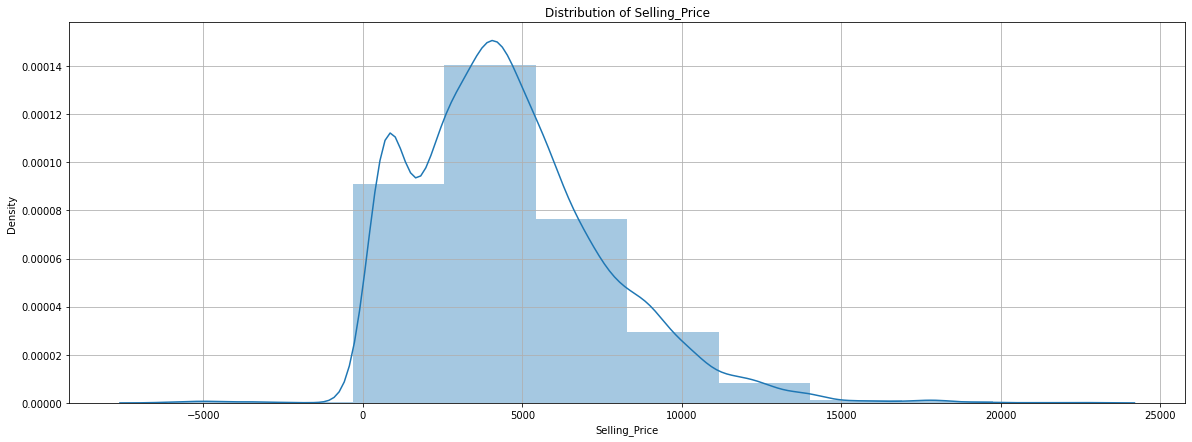

In [ ]:
plt.figure(figsize=(20,7))
sns.distplot(train_df.Selling_Price.values, bins=10)
plt.title('Distribution of Selling_Price')
plt.xlabel('Selling_Price')

plt.grid()
plt.show();

In [ ]:
final_train_df = pd.concat([train_features, train_df[['Selling_Price']]], axis = 1)
final_train_df

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,...,Product_Category_count_seconds,Product_Category_count_days_left,Product_Category_count_12_24,Grade_sum_Stall_no,Grade_sum_Market_Category,Grade_sum_Customer_name,Grade_sum_Loyalty_customer,Grade_sum_Product_Category,Grade_sum_Discount_avail,Grade_sum_Demand,Grade_sum_year,Grade_sum_weekofyear,Grade_sum_month,Grade_sum_dayofweek,Grade_sum_day,Grade_sum_weekend,Grade_sum_hour,Grade_sum_minutes,Grade_sum_seconds,Grade_sum_days_left,Grade_sum_12_24,Grade_count_Stall_no,Grade_count_Market_Category,Grade_count_Customer_name,Grade_count_Loyalty_customer,Grade_count_Product_Category,Grade_count_Discount_avail,Grade_count_Demand,Grade_count_year,Grade_count_weekofyear,Grade_count_month,Grade_count_dayofweek,Grade_count_day,Grade_count_weekend,Grade_count_hour,Grade_count_minutes,Grade_count_seconds,Grade_count_days_left,Grade_count_12_24,Selling_Price
0,37.0,2,5687,1,3,1,68,0.0,376.0,11.0,2983.0,4713.0,0,0,1,0,0.858032,0,0,8428.0,5.929589,19.407902,0,5379.0,2.484907,3.415650,1476.0,0,0,1730.0,4580.5,3591.0,3819.5,0.609716,2015,34,8,5,22,1,...,949,949,949,15053.0,79914,2613453,370,2697,65.0,29811,1170832,16492,3951,1660,10592,144,8595,16223,17072,7419,12456,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,4185.947700
1,38.0,24,5253,1,3,0,51,0.0,397.0,12.0,7495.0,10352.0,0,0,1,0,0.858032,0,0,8809.5,5.983936,19.941581,0,6055.5,2.564949,3.559026,1597.0,0,0,2857.0,9289.5,8649.0,6627.5,0.609716,2016,12,3,6,27,1,...,949,949,949,171176.0,1396225,30879795,4043,30105,992.0,338551,13532796,184955,43584,19265,119797,1732,92016,186837,199675,88368,137256,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,9271.490256
2,9.0,447,7334,1,0,0,10,0.0,250.0,9.0,5752.0,7309.0,0,0,1,0,0.858032,0,0,4907.5,5.521461,15.832456,0,4159.0,2.302585,3.109126,1150.0,0,0,1557.0,8418.5,6912.5,3211.5,0.609716,2015,34,8,1,18,0,...,1006,1006,1006,171176.0,1396225,30879795,4043,30105,992.0,338551,13532796,184955,43584,19265,119797,1732,92016,186837,199675,88368,137256,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6715,6785.701362
3,50.0,23,106,1,2,2,48,0.0,144.0,13.0,5090.0,20814.0,0,0,1,0,0.858032,0,0,1824.0,4.969813,12.027746,0,6740.0,2.639057,3.696846,1444.0,0,0,15724.0,7834.0,9757.0,9768.0,0.609716,2016,13,3,0,28,0,...,965,965,965,42233.0,275176,7741064,1019,7720,256.0,87165,3422128,43255,10176,4725,29825,401,22890,48365,49891,22813,34260,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,13028.917824
4,7.0,63,2668,1,8,1,35,1.0,211.0,4.0,2430.0,9261.0,0,0,1,0,0.141968,0,0,3285.0,5.351858,14.548769,0,909.0,1.609438,2.160247,611.0,0,0,6831.0,3534.0,8159.5,9087.0,0.609716,2016,13,3,1,29,0,...,1021,1021,1021,15053.0,79914,2613453,370,2697,65.0,29811,1170832,16492,3951,1660,10592,144,8595,16223,17072,7419,12456,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,581,906.553935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6363,17.0,24,6189,1,9,0,47,0.0,614.0,10.0,8174.0,11266.0,0,0,1,0,0.858032,0,1,9625.0,6.419995,24.792472,0,4774.5,2.397895

In [ ]:
final_train_df['Selling_Price'] = np.abs(final_train_df.Selling_Price.values)

final_train_df.dropna(inplace=True)

In [ ]:
final_train_df.Selling_Price.isnull().values.sum()

0

# Feature Selection

## defining X and Y

In [ ]:
Y = final_train_df[["Selling_Price"]]
final_train_df.drop(["Selling_Price"], axis = 1, inplace=True)
X = final_train_df.copy()

In [ ]:
X = X.astype('float64')
test_features = test_features.astype('float64')

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6327 entries, 0 to 6367
Columns: 230 entries, Stall_no to Grade_count_12_24
dtypes: float64(230)
memory usage: 11.2 MB


In [ ]:
Y

,Selling_Price
0,4185.947700
1,9271.490256
2,6785.701362
3,13028.917824
4,906.553935
...,...
6363,10277.520192
6364,4501.837200
6365,10218.878775
6366,5359.493997


## Univariate Feature selection

In [ ]:
class UnivariateFeatureSelection:
    def __init__(self, n_features, scoring):
        valid_scoring = {"f_regression": f_regression,
                         "mutual_info_regression":mutual_info_regression}
        if scoring not in valid_scoring:
            raise Exception("Invalid scoring function")
        
        if isinstance(n_features, int):
            self.selection = SelectKBest(valid_scoring[scoring], k = n_features)
        elif isinstance(n_features, float):
            self.selection = SelectPercentile( valid_scoring[scoring],
                                              percentile=int(n_features * 100))
        else: 
            raise Exception("Invalid type of feature")

    def fit(self, X, y):
        return self.selection.fit(X, y)

    def transform(self, X):
        return self.selection.transform(X)

    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)

In [ ]:
ufs = UnivariateFeatureSelection(n_features=0.1, scoring="f_regression")
ufs.fit(X, Y)
ufs_X_transformed = ufs.transform(X)
ufs_X_transformed.shape

(6327, 23)

## Recursive Feauture elimination

### For RandomForestRegressor

In [ ]:
# %%time
# model = RandomForestRegressor()

# rfe = RFE(estimator = model, 
#           n_features_to_select = 10)
# rfe.fit(X, Y)
# rfe_X_transformed = rfe.transform(X)
# rfe_test_features = rfe.transform(test_features)

In [ ]:
# X.columns[rfe.get_support()]

**O/P** : ['Discount_avail', 'Minimum_price', 'Maximum_price',
       'freq_encode_discount_avail', 'ranked_charges_1', 'range_price',
       'ranked_Minimum_price', 'ranked_Maximum_price', 'ranked_range_price',
       'ranked_Grade']

### For DecisionTreeRegressor

In [ ]:
%%time
model = DecisionTreeRegressor()

rfe = RFE(estimator = model, 
          n_features_to_select = 15)
rfe.fit(X, Y)
rfe_X_transformed = rfe.transform(X)
rfe_test_features = rfe.transform(test_features)

CPU times: user 1min 57s, sys: 76 ms, total: 1min 57s
Wall time: 1min 58s


In [ ]:
list(X.columns[rfe.get_support()])

['Customer_name',
 'Minimum_price',
 'Maximum_price',
 'Discount_avail_null',
 'freq_encode_discount_avail',
 'log_charges_1',
 'total_charges',
 'range_price',
 'ranked_Minimum_price',
 'ranked_Maximum_price',
 'ranked_range_price',
 'ranked_Product_Category',
 'ranked_Grade',
 'Cus_sum_Demand',
 'Market_Category_sum_Grade']

**O/P_10** : ['Minimum_price',
 'Maximum_price',
 'Discount_avail_null',
 'freq_encode_discount_avail',
 'log_charges_1',
 'range_price',
 'ranked_Minimum_price',
 'ranked_Maximum_price',
 'ranked_Grade',
 'Market_Category_sum_Grade']

 **O/P_15** : ['Customer_name',
 'Minimum_price',
 'Maximum_price',
 'Discount_avail_null',
 'freq_encode_discount_avail',
 'log_charges_1',
 'total_charges',
 'range_price',
 'ranked_Minimum_price',
 'ranked_Maximum_price',
 'ranked_range_price',
 'ranked_Product_Category',
 'ranked_Grade',
 'Cus_sum_Demand',
 'Market_Category_sum_Grade']

### For AdaBoost

In [ ]:
# %%time
# model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse'))

# rfe = RFE(estimator = model, 
#           n_features_to_select = 10)
# rfe.fit(X, Y)
# rfe_X_transformed = rfe.transform(X)
# rfe_test_features = rfe.transform(test_features)

CPU times: user 1h 8min 32s, sys: 2 s, total: 1h 8min 34s
Wall time: 1h 8min 51s


In [ ]:
# list(X.columns[rfe.get_support()])

['Discount_avail',
 'Minimum_price',
 'Maximum_price',
 'freq_encode_discount_avail',
 'log_charges_1',
 'range_price',
 'ranked_Minimum_price',
 'ranked_Maximum_price',
 'ranked_range_price',
 'ranked_Grade']

**O/P** : ['Discount_avail',
 'Minimum_price',
 'Maximum_price',
 'freq_encode_discount_avail',
 'log_charges_1',
 'range_price',
 'ranked_Minimum_price',
 'ranked_Maximum_price',
 'ranked_range_price',
 'ranked_Grade']

# Lets train

## DecisionTreeRegressor

In [ ]:
dtr = DecisionTreeRegressor()
dtr.fit(rfe_X_transformed, Y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
dtr_y_pred = dtr.predict(rfe_X_transformed)
print(f"Train score : {evaluator(dtr_y_pred, Y)}")
print(f"RMSE : {mean_squared_error(dtr_y_pred, Y)**0.5}")

Train score : 100.0
RMSE : 0.0


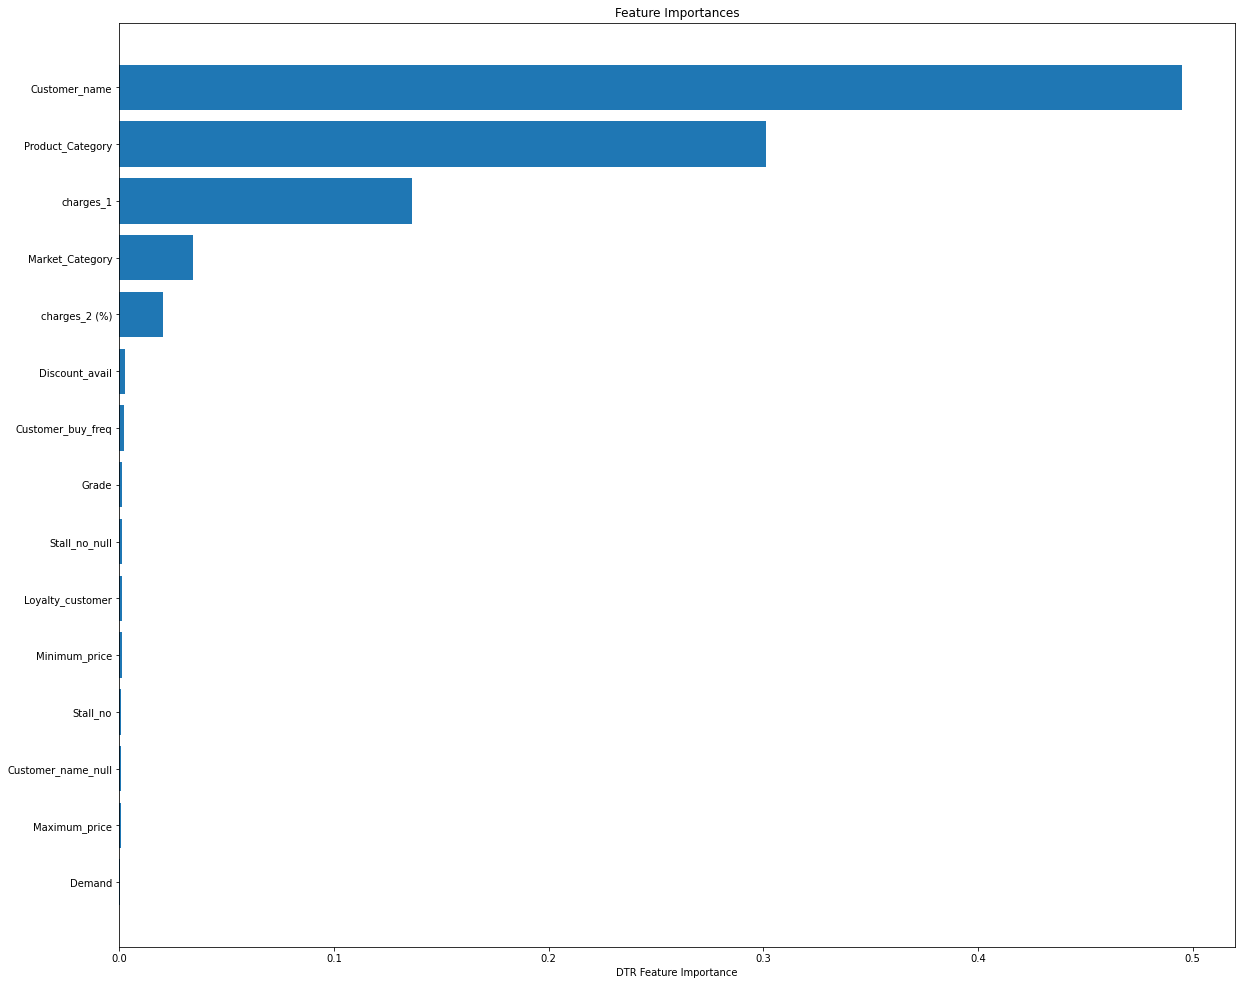

In [ ]:
importances = dtr.feature_importances_ 
idxs = np.argsort(importances)
col_names = list(X)

plt.figure(figsize = (20,17))
plt.title('Feature Importances')
plt.barh(range(len(idxs[:20])), importances[idxs[:20]], align='center')
plt.yticks(range(len(idxs[:20])), [col_names[i] for i in idxs[:20]])
plt.xlabel('DTR Feature Importance')
plt.show();

## RandomForestRegressor

In [ ]:
rfr = RandomForestRegressor(verbose=1, criterion='mse')

rfr.fit(rfe_X_transformed,Y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)

In [ ]:
rfr_y_pred = rfr.predict(rfe_X_transformed)
print(f"Train score : {evaluator(rfr_y_pred, Y)}")
print(f"RMSE : {mean_squared_error(rfr_y_pred, Y)**0.5}")

Train score : 99.90119163445914
RMSE : 111.82897055420426


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


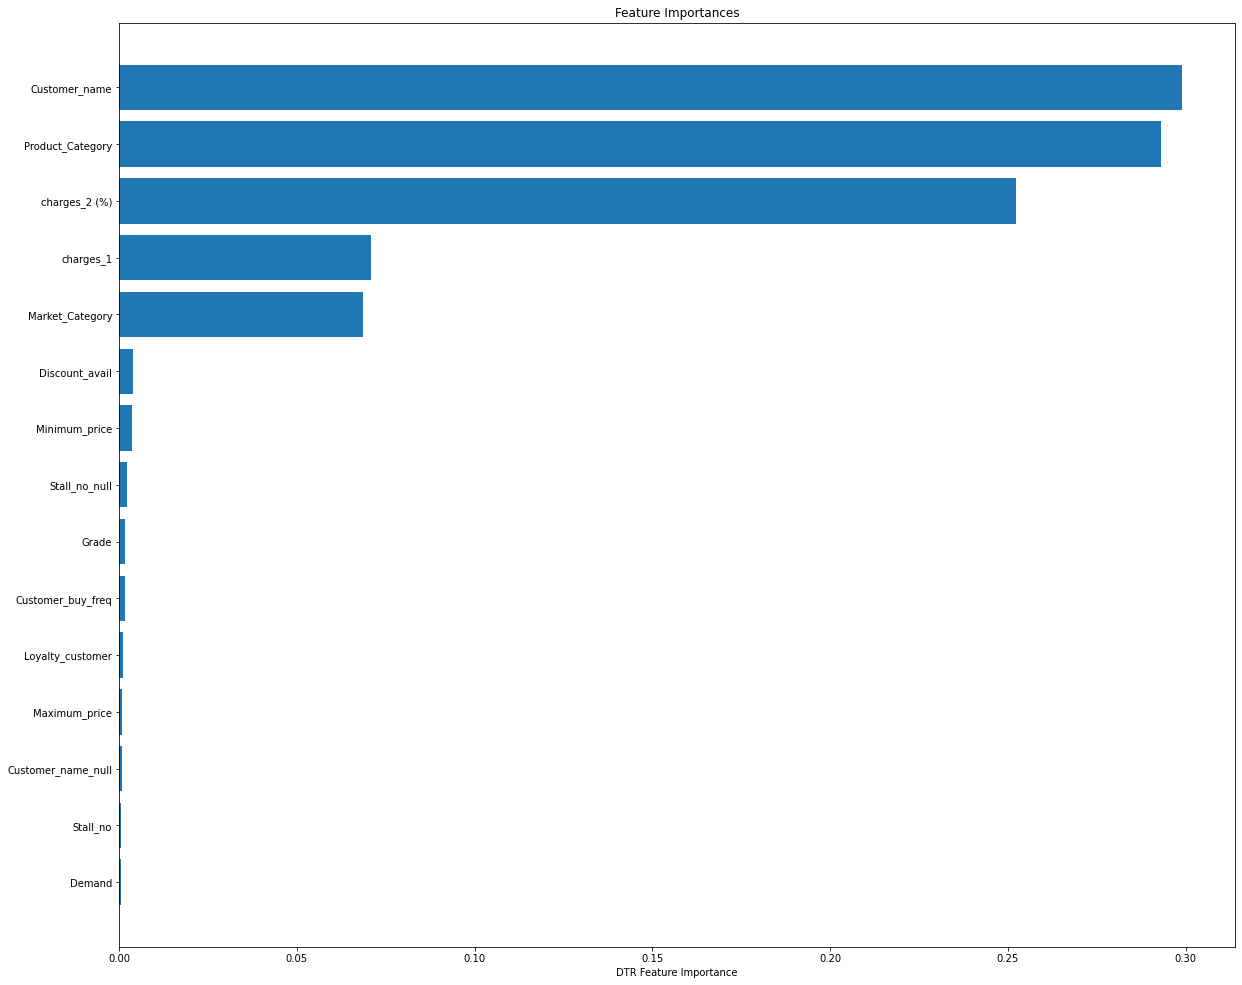

In [ ]:
importances = rfr.feature_importances_ 
idxs = np.argsort(importances)
col_names = list(X)

plt.figure(figsize = (20,17))
plt.title('Feature Importances')
plt.barh(range(len(idxs[:20])), importances[idxs[:20]], align='center')
plt.yticks(range(len(idxs[:20])), [col_names[i] for i in idxs[:20]])
plt.xlabel('DTR Feature Importance')
plt.show();

## ADABOOST_dtr

In [ ]:
adaboost = AdaBoostRegressor(base_estimator=dtr, n_estimators=10, loss='square')

adaboost.fit(rfe_X_transformed,Y)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

In [ ]:
adaboost_y_pred = adaboost.predict(rfe_X_transformed)
print(f"Train score : {evaluator(adaboost_y_pred, Y)}")
print(f"RMSE : {mean_squared_error(adaboost_y_pred, Y)**0.5}")

Train score : 99.97995559237965
RMSE : 66.8718529202172


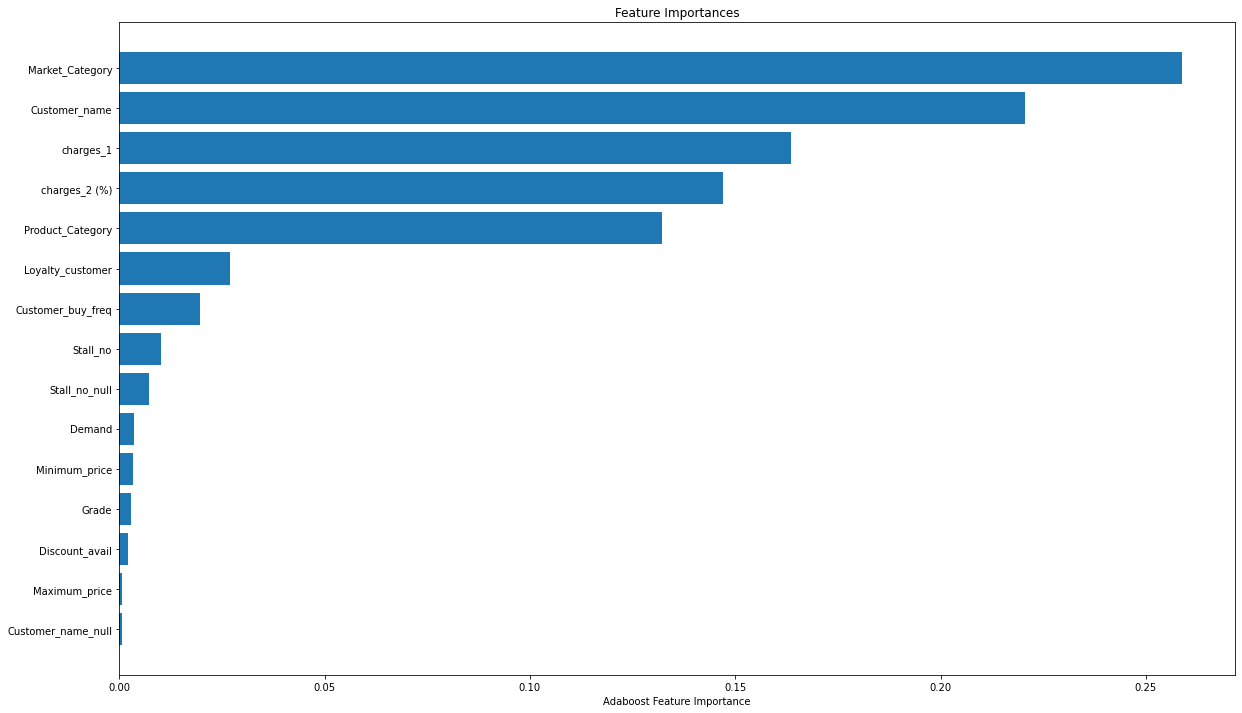

In [ ]:
importances = adaboost.feature_importances_ 
idxs = np.argsort(importances)
col_names = list(final_train_df.columns[:-1])

plt.figure(figsize = (20,12))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('Adaboost Feature Importance')
plt.show();

## ADABOOST_dtr

In [ ]:
adaboost_xT = AdaBoostRegressor(base_estimator=xtraTreeRegressor, n_estimators=10, loss='square')

adaboost_xT.fit(rfe_X_transformed,Y)

AdaBoostRegressor(base_estimator=ExtraTreesRegressor(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                             

In [ ]:
adaboost_xT_y_pred = adaboost_xT.predict(rfe_X_transformed)
print(f"Train score : {evaluator(adaboost_xT_y_pred, Y)}")
print(f"RMSE : {mean_squared_error(adaboost_xT_y_pred, Y)**0.5}")

Train score : 99.97493794474738
RMSE : 69.85678718278699


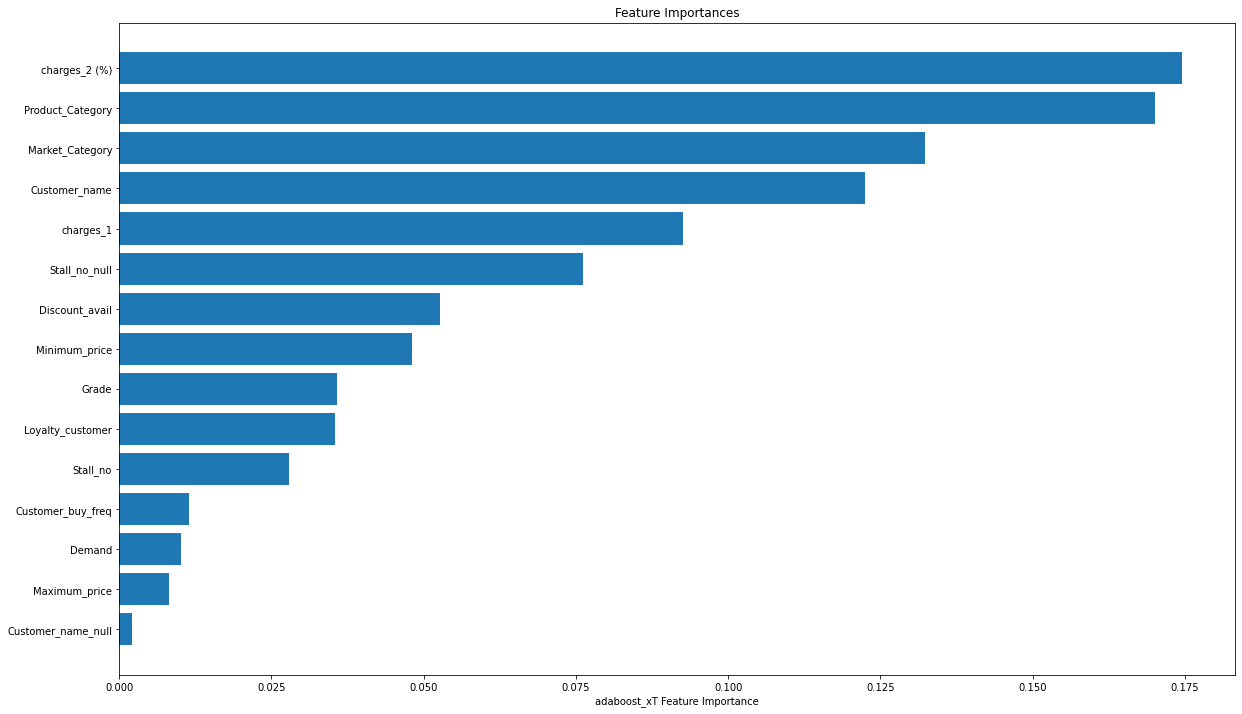

In [ ]:
importances = adaboost_xT.feature_importances_ 
idxs = np.argsort(importances)
col_names = list(final_train_df.columns[:-1])

plt.figure(figsize = (20,12))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('adaboost_xT Feature Importance')
plt.show();

## XGBOOST

In [ ]:
xgboost = XGBRegressor(verbose = 2)

xgboost.fit(rfe_X_transformed, Y)

[08:05:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=2, verbosity=1)

In [ ]:
xgboost_y_pred = xgboost.predict(rfe_X_transformed)
print(f"Train score : {evaluator(xgboost_y_pred,Y)}")
print(f"RMSE : {mean_squared_error(xgboost_y_pred, Y)**0.5}")

Train score : 99.82672577963284
RMSE : 296.9182551725863


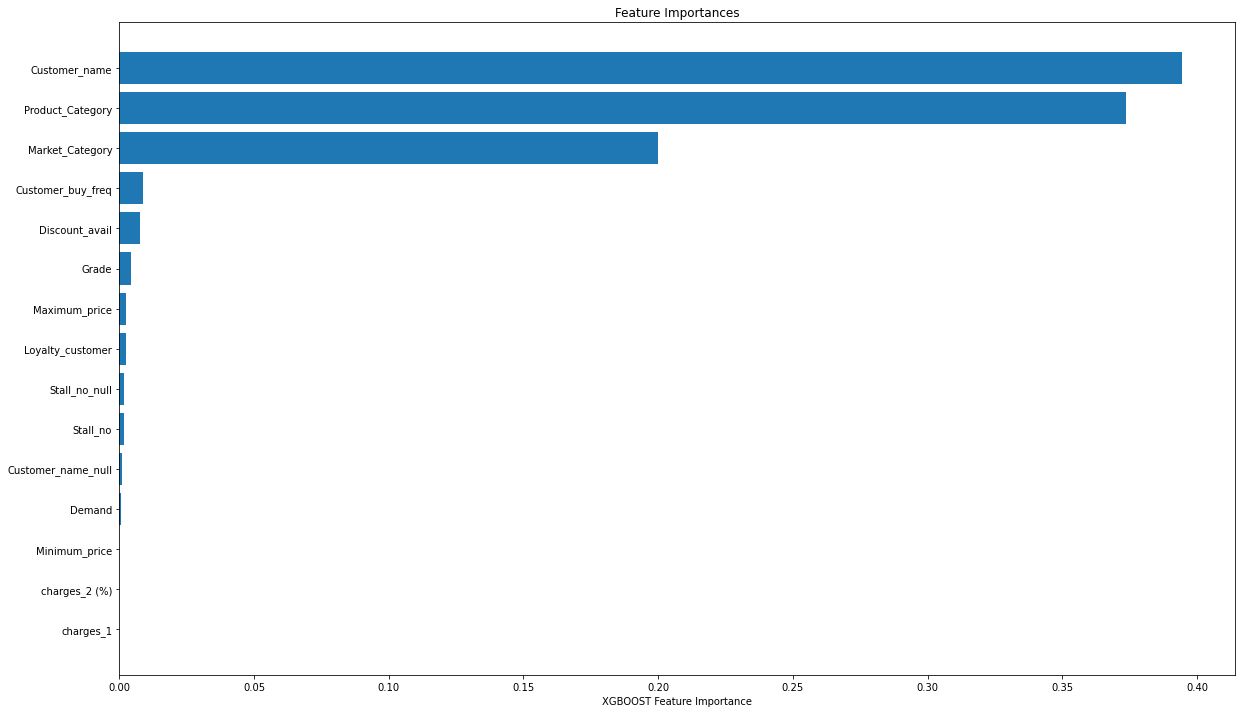

In [ ]:
importances = xgboost.feature_importances_ 
idxs = np.argsort(importances)
col_names = list(final_train_df.columns[:-1])

plt.figure(figsize = (20,12))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('XGBOOST Feature Importance')
plt.show();

## ExtratreeRegressor

In [ ]:
xtraTreeRegressor = ExtraTreesRegressor()

xtraTreeRegressor.fit(rfe_X_transformed, Y)

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
xtraTreeRegressor_y_pred = xtraTreeRegressor.predict(rfe_X_transformed)
print(f"Train score : {evaluator(xtraTreeRegressor_y_pred,Y)}")
print(f"RMSE : {mean_squared_error(xtraTreeRegressor_y_pred, Y)**0.5}")

Train score : 100.0
RMSE : 7.537067916155023e-12


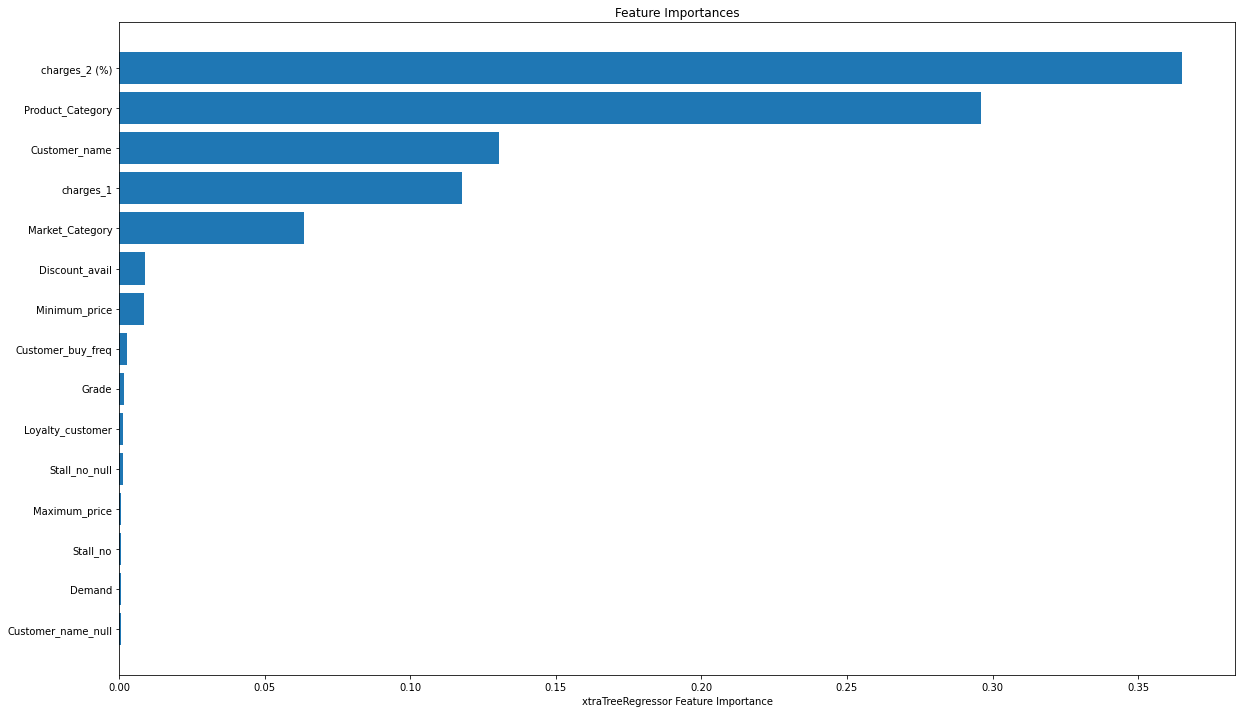

In [ ]:
importances = xtraTreeRegressor.feature_importances_ 
idxs = np.argsort(importances)
col_names = list(final_train_df.columns[:-1])

plt.figure(figsize = (20,12))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [col_names[i] for i in idxs])
plt.xlabel('xtraTreeRegressor Feature Importance')
plt.show();

## LightGBM

In [ ]:
lightXBM = LGBMRegressor()

lightXBM.fit(rfe_X_transformed, Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lightXBM_y_pred = lightXBM.predict(rfe_X_transformed)
print(f"Train score : {evaluator(lightXBM_y_pred,Y)}")
print(f"RMSE : {mean_squared_error(lightXBM_y_pred, Y)**0.5}")

Train score : 99.87596044210837
RMSE : 206.25520476402326


## CatBoostRegressor

In [ ]:
catboost = CatBoostRegressor(loss_function='RMSE')
catboost.fit(rfe_X_transformed, Y)

Learning rate set to 0.054202
0:	learn: 2814.0413920	total: 4.87ms	remaining: 4.87s
1:	learn: 2689.5550419	total: 9.23ms	remaining: 4.61s
2:	learn: 2562.4442871	total: 13.5ms	remaining: 4.49s
3:	learn: 2445.9518852	total: 17.8ms	remaining: 4.42s
4:	learn: 2332.3021176	total: 22.1ms	remaining: 4.39s
5:	learn: 2224.3681187	total: 26.5ms	remaining: 4.39s
6:	learn: 2122.6436668	total: 30.8ms	remaining: 4.37s
7:	learn: 2024.1865131	total: 34.9ms	remaining: 4.33s
8:	learn: 1932.1869699	total: 39.3ms	remaining: 4.32s
9:	learn: 1843.2995848	total: 43.5ms	remaining: 4.31s
10:	learn: 1758.8498472	total: 47.8ms	remaining: 4.3s
11:	learn: 1683.2586879	total: 52.2ms	remaining: 4.29s
12:	learn: 1610.7483811	total: 56.4ms	remaining: 4.28s
13:	learn: 1540.4240809	total: 60.9ms	remaining: 4.29s
14:	learn: 1473.6709108	total: 65.2ms	remaining: 4.28s
15:	learn: 1408.4709037	total: 69.7ms	remaining: 4.29s
16:	learn: 1349.0850202	total: 74.1ms	remaining: 4.28s
17:	learn: 1292.2859136	total: 78.4ms	remainin

In [ ]:
catboost_y_pred = catboost.predict(rfe_X_transformed)
print(f"Train score : {evaluator(catboost_y_pred,Y)}")
print(f"RMSE : {mean_squared_error(catboost_y_pred, Y)**0.5}")

Train score : 99.87048326208348
RMSE : 138.44171815248802


## GBTreesRegression

In [ ]:
gboost = GradientBoostingRegressor()
gboost.fit(rfe_X_transformed, Y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
gboost_y_pred = gboost.predict(rfe_X_transformed)
print(f"Train score : {evaluator(gboost_y_pred,Y)}")
print(f"RMSE : {mean_squared_error(gboost_y_pred, Y)**0.5}")

Train score : 99.82464544240304
RMSE : 280.440610341247


# Grid Search and Ensemble

At this point ExtraTrees and RandomForest are giving good scores.

## Scorerer


In [ ]:
def rmse(Y, Y_pred):
    return mean_squared_error(Y_pred, Y)**0.5
    
rmse = make_scorer(rmse, greater_is_better = False)

In [ ]:
gsc_xtraTR = GridSearchCV(
    estimator=xtraTreeRegressor,
    param_grid={
        'n_estimators': range(50,126,25),
        'max_features': range(10,15,20),
        'min_samples_leaf': range(20,50,5),
        'min_samples_split': range(15,36,5),
    },
    scoring=rmse,
    cv=5
)

grid_result = gsc_xtraTR.fit(rfe_X_transformed, Y)


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -416.353242 using {'max_features': 10, 'min_samples_leaf': 20, 'min_samples_split': 35, 'n_estimators': 75}


In [ ]:
xtraTreeRegressor = ExtraTreesRegressor(**grid_result.best_params_)

xtraTreeRegressor.fit(rfe_X_transformed, Y)
xtraTreeRegressor_y_pred = xtraTreeRegressor.predict(rfe_X_transformed)
print(f"Train score : {evaluator(xtraTreeRegressor_y_pred,Y)}")
print(f"RMSE : {mean_squared_error(xtraTreeRegressor_y_pred, Y)**0.5}")

Train score : 99.85199657831112
RMSE : 376.03940844530314


## Applying Voting

In [ ]:
%%time

final_model = VotingRegressor([('xtraTreeReg', xtraTreeRegressor),('randomForReg',rfr)],n_jobs=-1)

final_model.fit(rfe_X_transformed,Y)

Y_pred = final_model.predict(rfe_X_transformed)
print(f"Train score : {evaluator(Y_pred,Y)}")
print(f"RMSE : {mean_squared_error(Y_pred, Y)**0.5}")

Train score : 99.92065486982736
RMSE : 55.86376349293442
CPU times: user 491 ms, sys: 342 ms, total: 834 ms
Wall time: 9.31 s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


# Submission

In [ ]:
test_features

,Stall_no,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Stall_no_null,Customer_name_null,Customer_buy_freq,Discount_avail_null,freq_encode_discount_avail,charges_1_null,charges_1_90th_quantile,ranked_charges_1,log_charges_1,power_transform_charges_1,charges_2 (%)_null,ranked_charges_2,log_charges_2,power_transform_charge_2,total_charges,Minimum_price_null,Maximum_price_null,range_price,ranked_Minimum_price,ranked_Maximum_price,ranked_range_price,freq_encode_loyalty,year,weekofyear,month,dayofweek,day,weekend,...,Product_Category_count_minutes,Product_Category_count_seconds,Product_Category_count_days_left,Product_Category_count_12_24,Grade_sum_Stall_no,Grade_sum_Market_Category,Grade_sum_Customer_name,Grade_sum_Loyalty_customer,Grade_sum_Product_Category,Grade_sum_Discount_avail,Grade_sum_Demand,Grade_sum_year,Grade_sum_weekofyear,Grade_sum_month,Grade_sum_dayofweek,Grade_sum_day,Grade_sum_weekend,Grade_sum_hour,Grade_sum_minutes,Grade_sum_seconds,Grade_sum_days_left,Grade_sum_12_24,Grade_count_Stall_no,Grade_count_Market_Category,Grade_count_Customer_name,Grade_count_Loyalty_customer,Grade_count_Product_Category,Grade_count_Discount_avail,Grade_count_Demand,Grade_count_year,Grade_count_weekofyear,Grade_count_month,Grade_count_dayofweek,Grade_count_day,Grade_count_weekend,Grade_count_hour,Grade_count_minutes,Grade_count_seconds,Grade_count_days_left,Grade_count_12_24
6368,39.0,205.0,3848.0,0.0,3.0,0.0,90.0,0.0,380.0,16.0,2576.0,3340.0,0.0,0.0,1.0,0.0,0.858032,0.0,0.0,8492.5,5.940171,19.510681,0.0,8824.0,2.833213,4.082483,1980.0,0.0,0.0,764.0,3804.5,1655.5,677.0,0.390284,2016.0,2.0,1.0,2.0,13.0,0.0,...,949.0,949.0,949.0,949.0,171176.0,1396225.0,30879795.0,4043.0,30105.0,992.0,338551.0,13532796.0,184955.0,43584.0,19265.0,119797.0,1732.0,92016.0,186837.0,199675.0,88368.0,137256.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0
6369,49.0,3.0,3803.0,1.0,3.0,0.0,87.0,0.0,393.0,16.0,1202.0,1955.0,0.0,0.0,1.0,0.0,0.858032,0.0,0.0,8729.5,5.973810,19.841035,0.0,8824.0,2.833213,4.082483,1993.0,0.0,0.0,753.0,1232.5,468.0,664.0,0.609716,2015.0,34.0,8.0,6.0,23.0,1.0,...,949.0,949.0,949.0,949.0,171176.0,1396225.0,30879795.0,4043.0,30105.0,992.0,338551.0,13532796.0,184955.0,43584.0,19265.0,119797.0,1732.0,92016.0,186837.0,199675.0,88368.0,137256.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0,6715.0
6370,1.0,183.0,718.0,0.0,9.0,2.0,55.0,0.0,493.0,9.0,7175.0,15715.0,0.0,0.0,1.0,0.0,0.858032,0.0,1.0,9032.0,6.200509,22.218611,0.0,4159.0,2.302585,3.109126,1393.0,0.0,0.0,8540.0,9165.0,9565.0,9348.5,0.390284,2015.0,46.0,11.0,5.0,14.0,1.0,...,960.0,960.0,960.0,960.0,42233.0,275176.0,7741064.0,1019.0,7720.0,256.0,87165.0,3422128.0,43255.0,10176.0,4725.0,29825.0,401.0,22890.0,48365.0,49891.0,22813.0,34260.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0,1698.0
6371,8.0,358.0,7512.0,1.0,0.0,3.0,86.0,0.0,303.0,16.0,5404.0,13078.0,0.0,0.0,1.0,0.0,0.858032,0.0,0.0,7210.0,5.713733,17.426034,0.0,8824.0,2.833213,4.082483,1903.0,0.0,0.0,7674.0,8134.0,9222.5,9247.0,0.609716,2015.0,47.0,11.0,5.0,21.0,1.0,...,1006.0,1006.0,1006.0,1006.0,20599.0,192746.0,3749418.0,542.0,3615.0,78.0,39956.0,1620320.0,21593.0,5125.0,2224.0,15060.0,192.0,11623.0,23636.0,24306.0,9864.0,16800.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0,804.0
6372,33.0,167.0,2881.0,0.0,9.0,0.0,27.0,0.0,567.0,16.0,4069.0,6244.0,0.0,0.0,1.0,0.0,0.858032,0.0,1.0,9382.0,6.340359,23.825756,0.0,8824.0,2.833213,4.082483,2167.0,0.0,0.0,2175.0,6547.0,5873.5,5207.5,0.390284,2015.0,19.0,5.0,2.0,6.0,0.0,...,960.0,960.0,960.0,960.0,171176.0,1396225.0,30879795.0,4043.0,30105.0,992.0,338551.0,13532796.0,184955.0,43584.0,19265.0,119797.0,1732.0

In [ ]:
# ufs_test_features = ufs.transform(test_features)
# test_selling_price = rfr.predict(ufs_test_features)
# test_selling_price

In [ ]:
test_selling_price_dtr = dtr.predict(rfe_test_features)
test_selling_price_rfr = rfr.predict(rfe_test_features)
test_selling_price_adaboost = adaboost.predict(rfe_test_features)
test_selling_price_adaboost_xT = adaboost_xT.predict(rfe_test_features)
test_selling_price_xgboost = xgboost.predict(rfe_test_features)
test_selling_price_xtraTreeRegressor = xtraTreeRegressor.predict(rfe_test_features)
test_selling_price_lightXBM = lightXBM.predict(rfe_test_features)
test_selling_price_catboost = catboost.predict(rfe_test_features)
test_selling_price_gboost = gboost.predict(rfe_test_features)

test_selling_price_final_model = final_model.predict(rfe_test_features)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
test_df["Selling_Price"] = np.abs(test_selling_price_final_model)
# test_df["Selling_Price"] = np.where(test_selling_price<0, 0, test_selling_price)


test_df.head()

,Product_id,Stall_no,instock_date,Market_Category,Customer_name,Loyalty_customer,Product_Category,Grade,Demand,Discount_avail,charges_1,charges_2 (%),Minimum_price,Maximum_price,Selling_Price
0,SCHE4YSTDVPVZVXW,39.0,2016-01-13 07:45:08.000,205,Ivanka,No,Fashion,0,90,0,380.0,16.0,2576.0,3340,3247.901564
1,ACCEGCATKHNRXUHW,49.0,2015-08-23 20:37:05.000,3,Isaak,Yes,Fashion,0,87,0,393.0,16.0,1202.0,1955,1941.361431
2,NKCE6GJ5XVJDXNNZ,1.0,2015-11-14 18:12:39.000,183,Analiese,No,Technology,2,55,0,493.0,9.0,7175.0,15715,11665.042569
3,NKCEB8BK3ZXDHDHM,8.0,2015-11-21 04:56:19.000,358,Rusty,Yes,Child_care,3,86,0,303.0,16.0,5404.0,13078,9347.496895
4,TOPEFDXSAHRNPF94,33.0,2015-05-06 15:09:46.000,167,Eloise,No,Technology,0,27,0,567.0,16.0,4069.0,6244,5945.000286


In [ ]:
test_df.Selling_Price.nunique()

3430

In [ ]:
submission = test_df[['Product_id', 'Selling_Price']]
submission_name = 'Submssion_54_final_model.csv'
submission.to_csv(submission_name, index = False)
files.download(submission_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>